In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from specutils.spectra.spectrum1d import Spectrum1D
from specutils.fitting.continuum import fit_generic_continuum
from specutils.fitting import fit_lines
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from specutils.fitting import find_lines_threshold
from astropy.nddata.nduncertainty import StdDevUncertainty
from astropy.convolution import convolve, Gaussian1DKernel
from specutils.fitting import fit_lines
from astropy.modeling.models import Linear1D
from astropy.modeling.fitting import LinearLSQFitter

In [2]:
f = h5py.File('20240521_0000007.h5', 'r')
dset=f['MatSpectra']

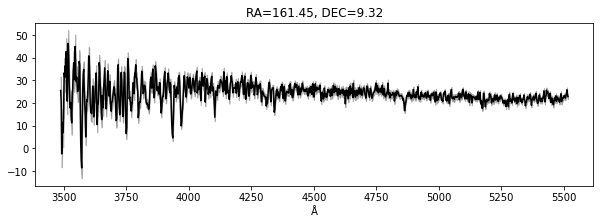

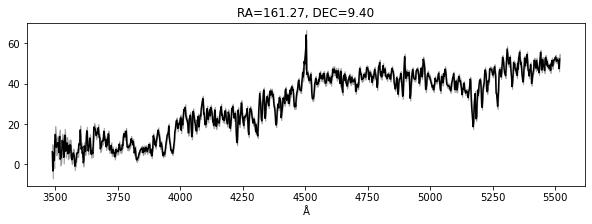

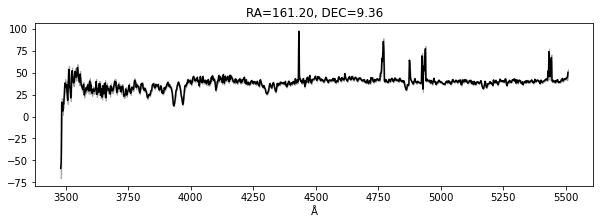

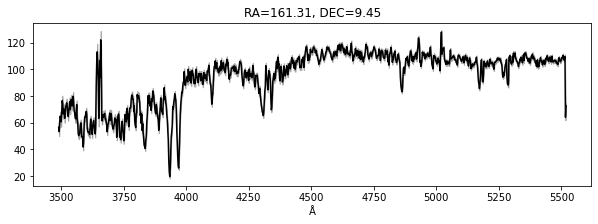

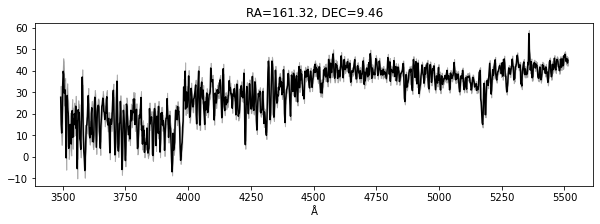

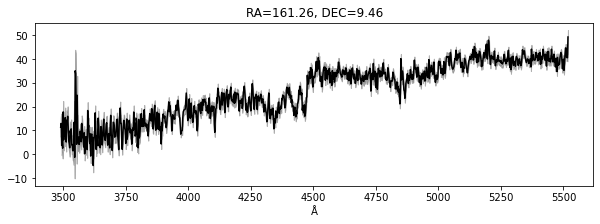

In [4]:
def plot_ps_spectrum(no,zoom=False):
    
    # Plot spectrum of PanSTARRS sources 
    
    x=np.arange(3470, 3470 + 1036 * 2, 2)
    fig,ax=plt.subplots(figsize=(10,3))
    ax.plot(x,dset[no][9],color='black')
    ax.fill_between(x,dset[no][9]+dset[no][3],dset[no][9]-dset[no][3],color='dimgrey',alpha=0.5,interpolate=False)
    ax.set_xlabel('\u00C5')
    ax.set_title(f"RA={dset[no][8]:.2f}, DEC={dset[no][2]:.2f}")
    if zoom!=False:
        ax.set_xlim(zoom[0],zoom[1])
    
for i in range(6):
    plot_ps_spectrum(i)

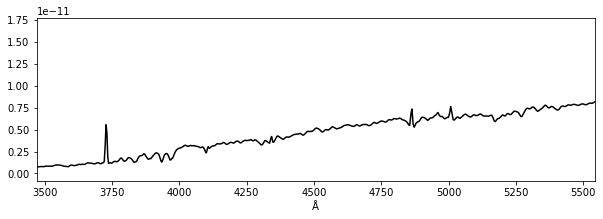

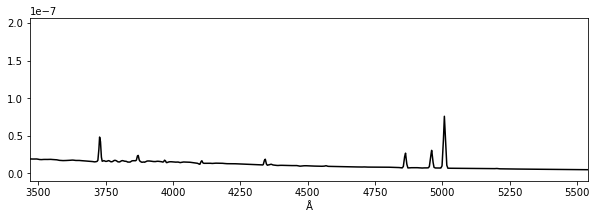

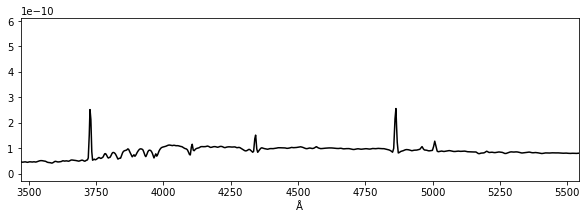

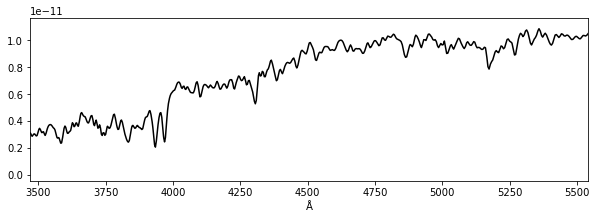

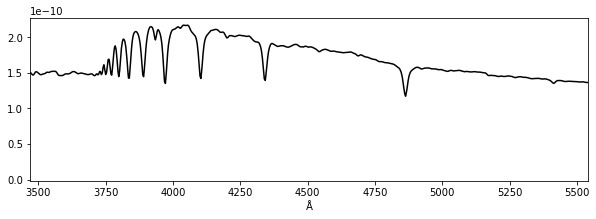

In [5]:
## Plot Luca's Template Spectra

with h5py.File('template_spectra.hdf5','r') as h5:
    wavelength = h5['wavelength'][()]
    flux = h5['amplitudes'][()]
    
for i in range(5):
    fig,ax=plt.subplots(figsize=(10,3))
    ax.plot(wavelength,flux[i],color='black')
    ax.set_xlim(3470, 3470 + 1036 * 2)
    ax.set_xlabel('\u00C5')

In [6]:
def normalise_and_plot(no, plot_continuum=False, ret=False, plot_spec=True):
    
    ## Continuum normalise spectra
    
    x=np.arange(3470, 3470 + 1036 * 2, 2)
    spectrum = Spectrum1D(flux=dset[no][9] * u.Jy, spectral_axis=x * u.um)

    fitted_continuum = fit_generic_continuum(spectrum=spectrum,model=Linear1D(),fitter=LinearLSQFitter())
    y_fit = fitted_continuum(x*u.um)
    normed = spectrum / y_fit
    
    if plot_continuum==True:
        fig,ax=plt.subplots(figsize=(10,3))
        ax.plot(x,dset[no][9],color='black')
        ax.plot(x,y_fit,color='red',linewidth=2)
        ax.fill_between(x,dset[no][9]+dset[no][3],dset[no][9]-dset[no][3],color='dimgrey',alpha=0.5,interpolate=False)
        ax.set_xlabel('\u00C5')
        ax.set_title(f"RA={dset[no][8]:.2f}, DEC={dset[no][2]:.2f}")
    
    if plot_spec==True:
        fig,ax=plt.subplots(figsize=(10,3))
        ax.plot(normed.spectral_axis,normed.flux,color='black')
        ax.fill_between(x,(dset[no][9]+dset[no][3])/y_fit,(dset[no][9]-dset[no][3])/y_fit,color='dimgrey',alpha=0.5,interpolate=False)
        ax.set_xlabel('\u00C5')
        ax.set_title(f"RA={dset[no][8]:.2f}, DEC={dset[no][2]:.2f}")
    
    if ret==True:
        
        return normed.spectral_axis, normed.flux, y_fit

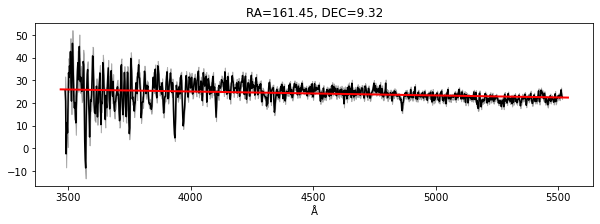

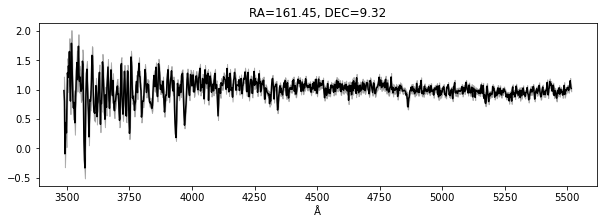

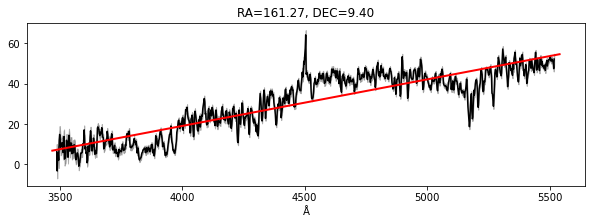

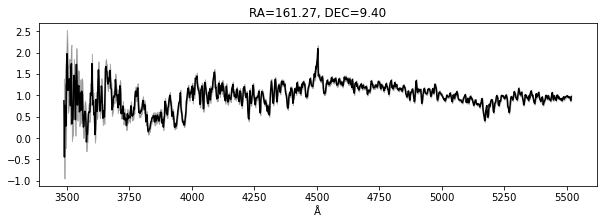

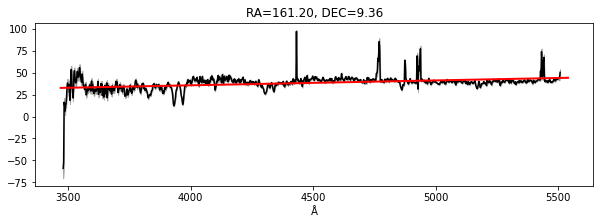

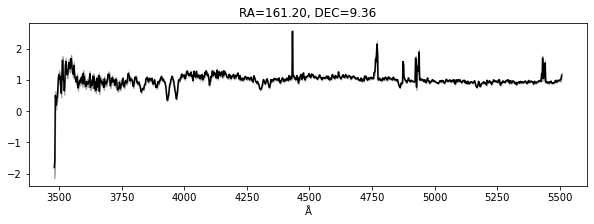

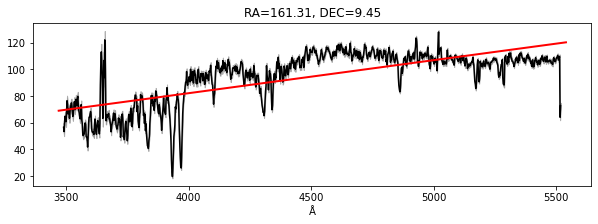

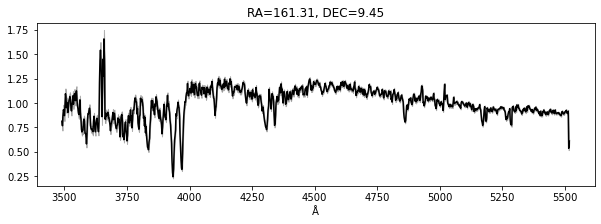

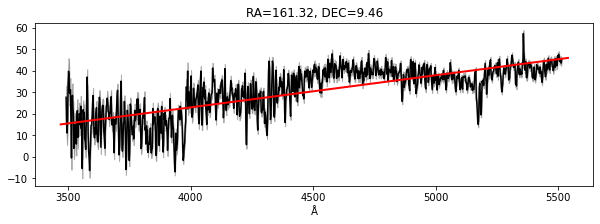

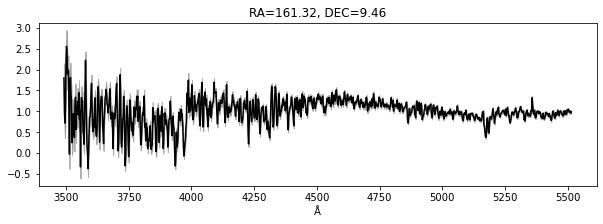

In [7]:
dat =  np.array([normalise_and_plot(i,plot_continuum=True,ret=True) for i in range(5)])
spaxes= dat[:,0]
fluxes=dat[:,1]
yfits=dat[:,2]

## Line Finding

In [14]:
lines=[5007,4959,3726,3729,6563,4861,3969,3934]
linelabels=['O III-1', 'O III-2', 'O II-1', 'O II-2', 'H', 'H', 'Ca-H', 'Ca-K']

def doppler(x):
    return x*1.144, x*0.004

def line_finding(no):
    
    sa, f, y_fit= normalise_and_plot(no, plot_spec=False, ret=True)
    spectrum=Spectrum1D(flux=f,spectral_axis=sa,uncertainty=StdDevUncertainty(dset[no][3]/y_fit.value))
    found = find_lines_threshold(spectrum, noise_factor=1) 
    found['line_center_index']=found['line_center_index'].astype('str')
    
    for i in range(len(lines)):
        req=np.where((found['line_center'].value>doppler(lines[i])[0]-doppler(lines[i])[1]) & (found['line_center'].value<doppler(lines[i])[0]+doppler(lines[i])[1]))
        found['line_center_index'][req]=linelabels[i]
        
    found.pprint(max_lines=-1, max_width=-1)

In [15]:
for i in range(5):
    line_finding(i)

line_center line_type  line_center_index
     um                                 
----------- ---------- -----------------
     3488.0   emission                 9
     3518.0   emission                24
     3600.0   emission                65
     3572.0 absorption                51
line_center line_type line_center_index
     um                                
----------- --------- -----------------
     3488.0  emission                 9
     3492.0  emission                11
     3500.0  emission                15
     3538.0  emission                34
     3600.0  emission                65
     4504.0  emission              Ca-K
line_center line_type  line_center_index
     um                                 
----------- ---------- -----------------
     4432.0   emission               481
     3480.0 absorption                 5
line_center line_type line_center_index
     um                                
----------- --------- -----------------
     3658.0  emission       


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


### Overplot

In [23]:
labels=['1','2','3','4','5']
colors=['violet','indigo','deepskyblue','green','brown']
linecolors=['blue','green','red','cyan','magenta','yellow','black','darkorange']

def overplot(no,which=100, zoom1=False, zoom2=False):
    
    fig,ax=plt.subplots(figsize=(15,10))
    
    ax.plot(spaxes[no],fluxes[no],color='black')
    ax.fill_between(spaxes[no],(dset[no][9]+dset[no][3])/yfits[no],(dset[no][9]-dset[no][3])/yfits[no],color='dimgrey',alpha=0.5,interpolate=False)
    ax.set_xlabel('\u00C5')
    ax.set_title(f"RA={dset[no][8]:.2f}, DEC={dset[no][2]:.2f}")

    for i in range(len(lines)):
        
        d1,d2=doppler(lines[i])
        if max(spaxes[no])<d1-d2 or min(spaxes[no])>d1+d2:
            continue
        ax.axvline(d1,label=linelabels[i],color=linecolors[i])   
        ax.axvspan(d1-d2,d1+d2,color=linecolors[i],alpha=0.1)

        
    for i in range(5):
        if (which!=100) & (which!=i):
            continue
        fact=min(-np.floor(np.log10(flux[i])))
        ax.plot(wavelength[(wavelength>=3470*1.144) & (wavelength<=(3470+1036*2)*1.144)],10**(fact)*flux[i][(wavelength>=3470) & (wavelength<=3470+1036*2)],color=colors[i],label=labels[i],linewidth=2)
    
    if zoom1!=False:
        ax.set_xlim(zoom1,zoom2)
    
    plt.legend()
    plt.show()

SyntaxError: invalid non-printable character U+00A0 (443343944.py, line 6)

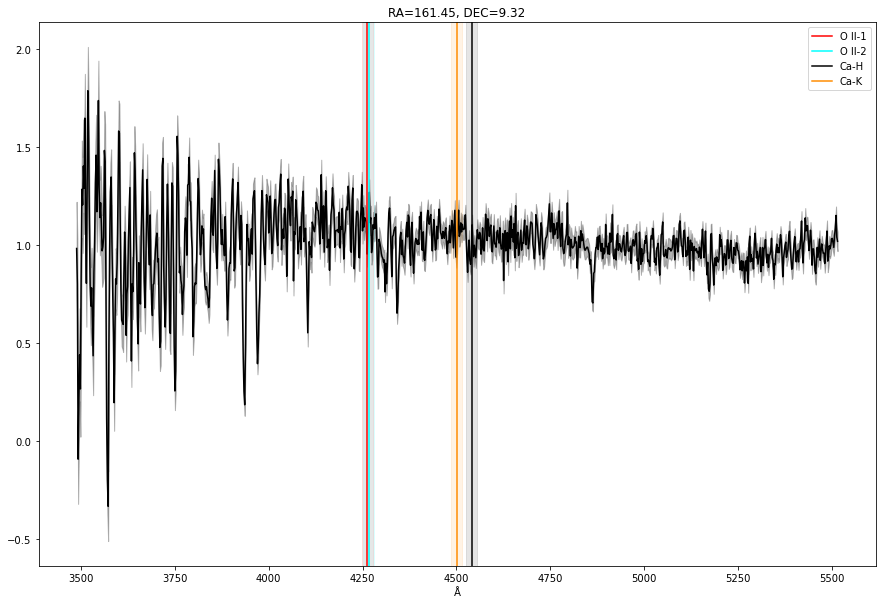

0 0


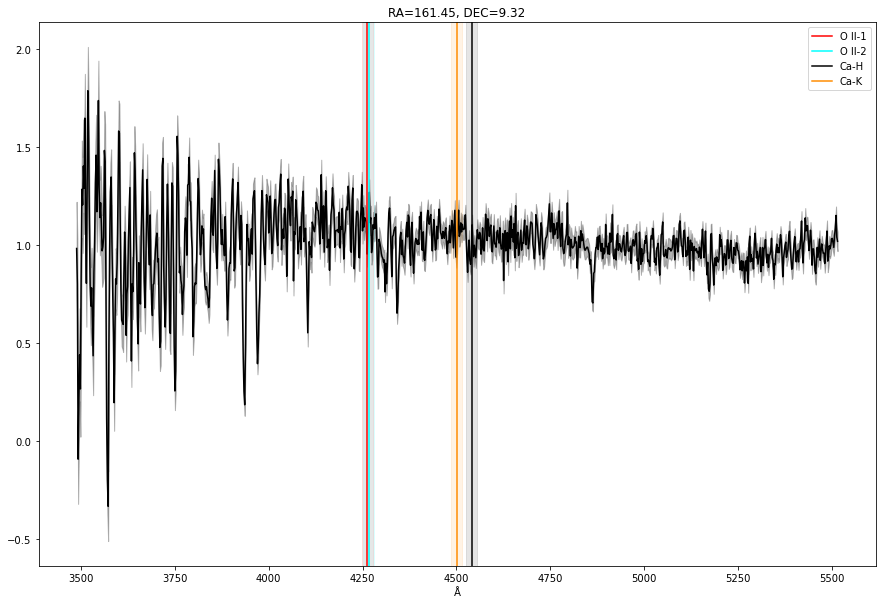

0 1


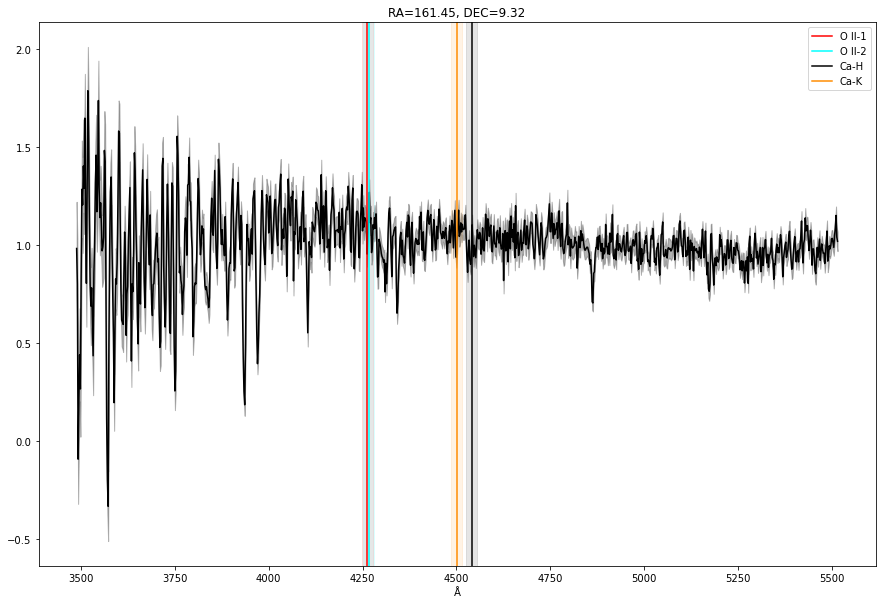

0 2


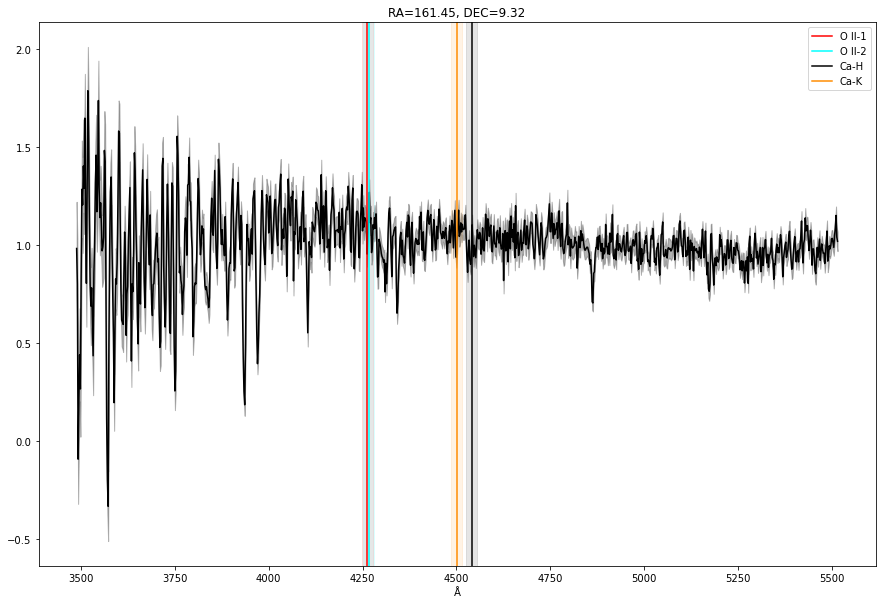

0 3


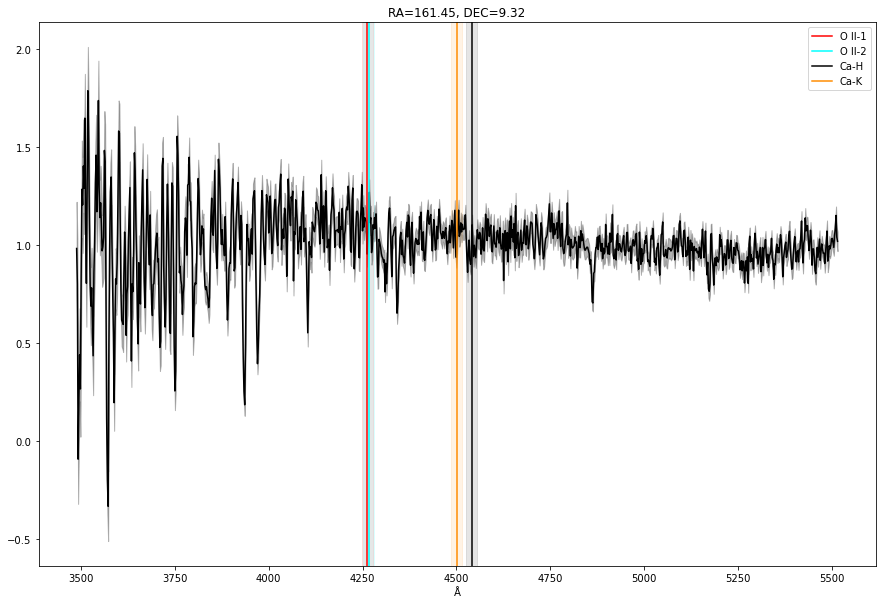

0 4


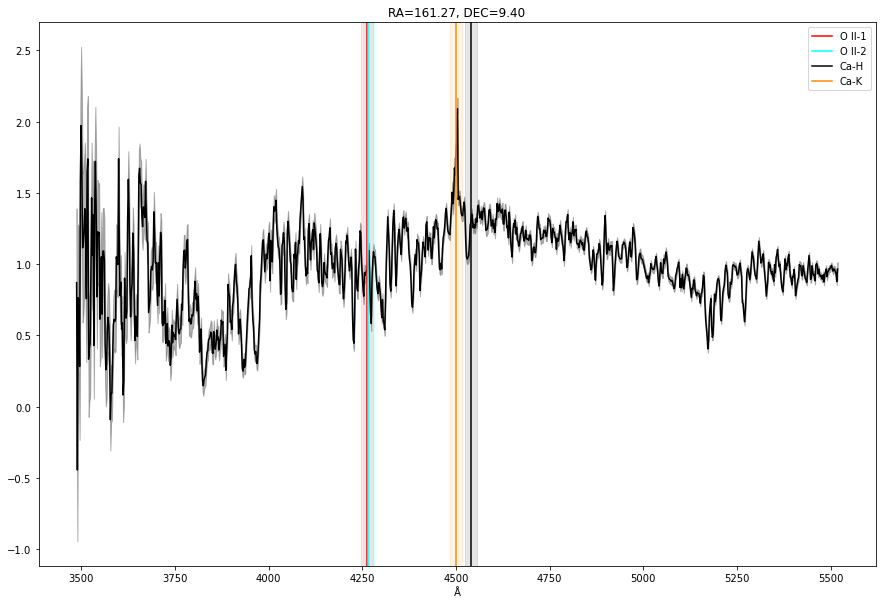

1 0


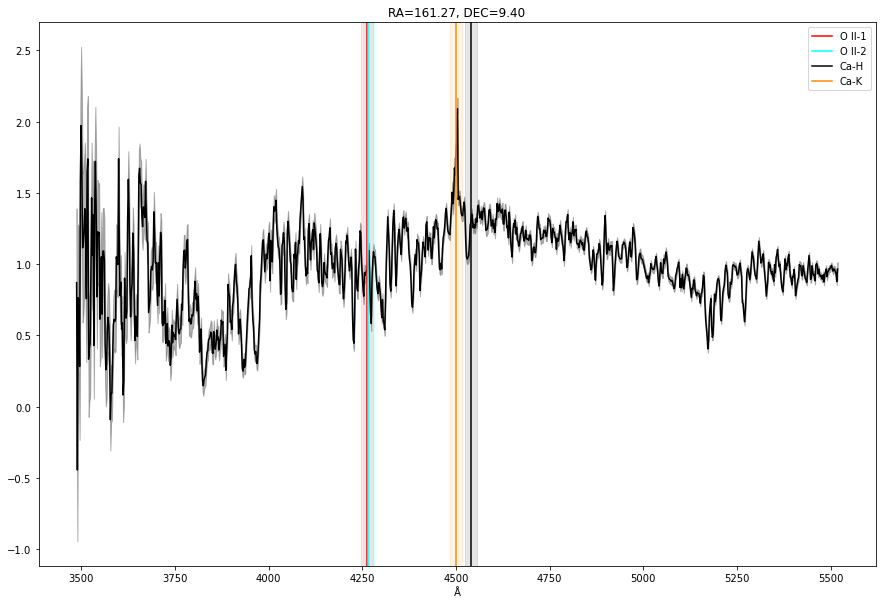

1 1


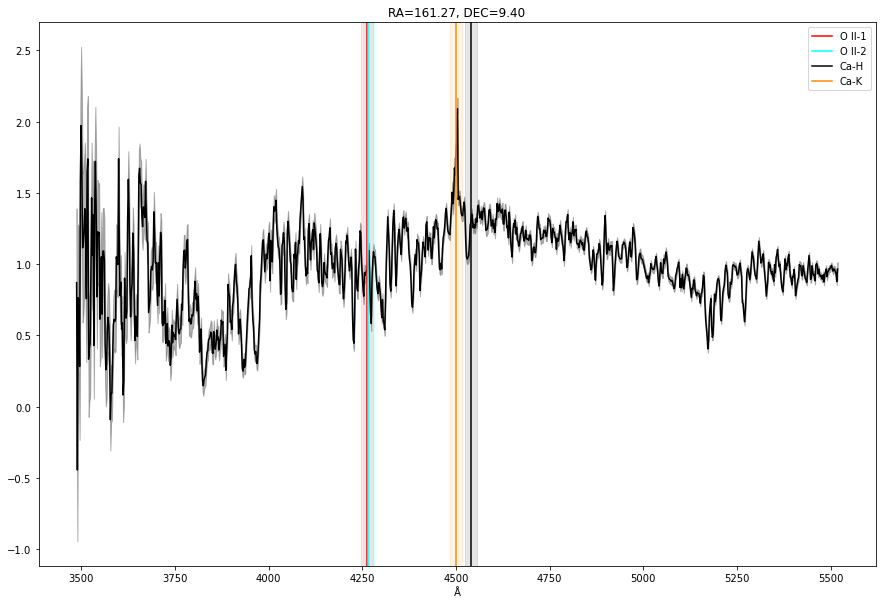

1 2


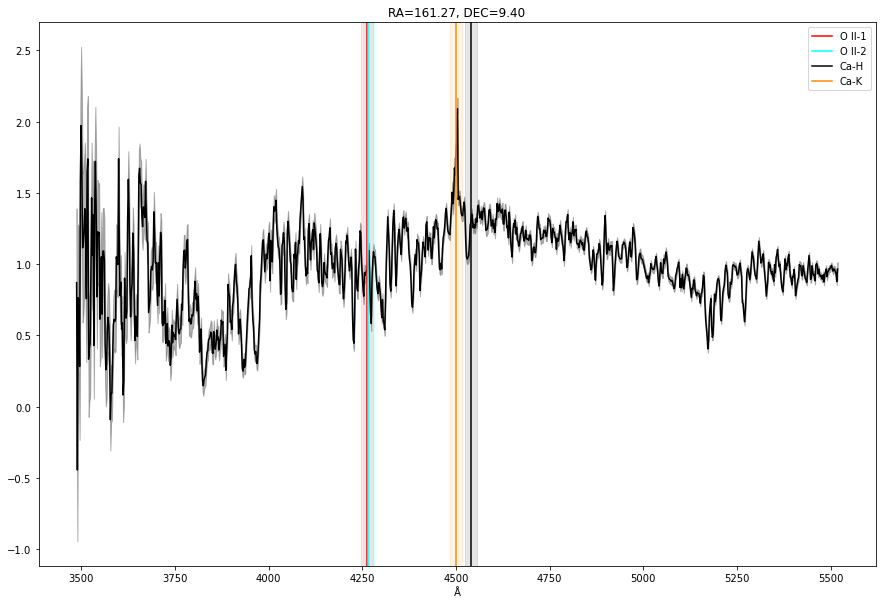

1 3


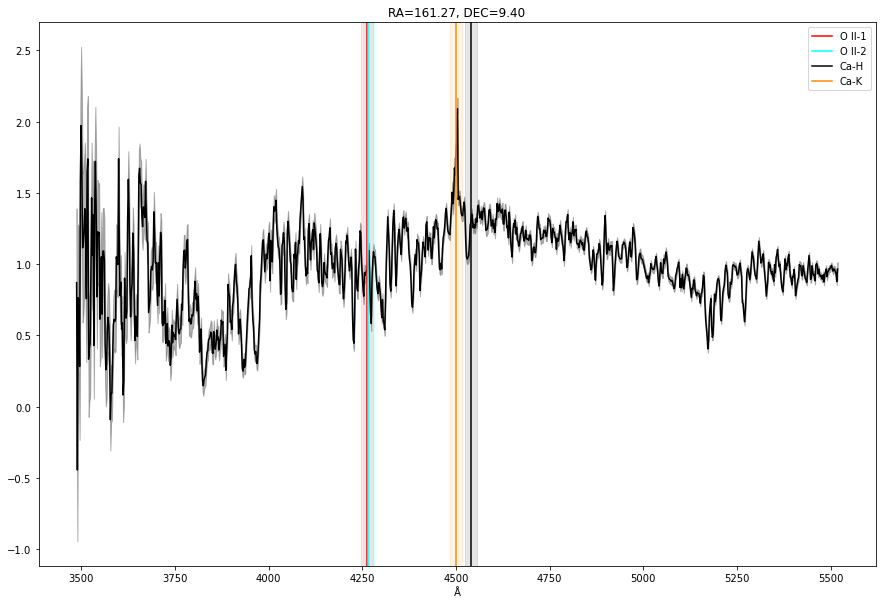

1 4


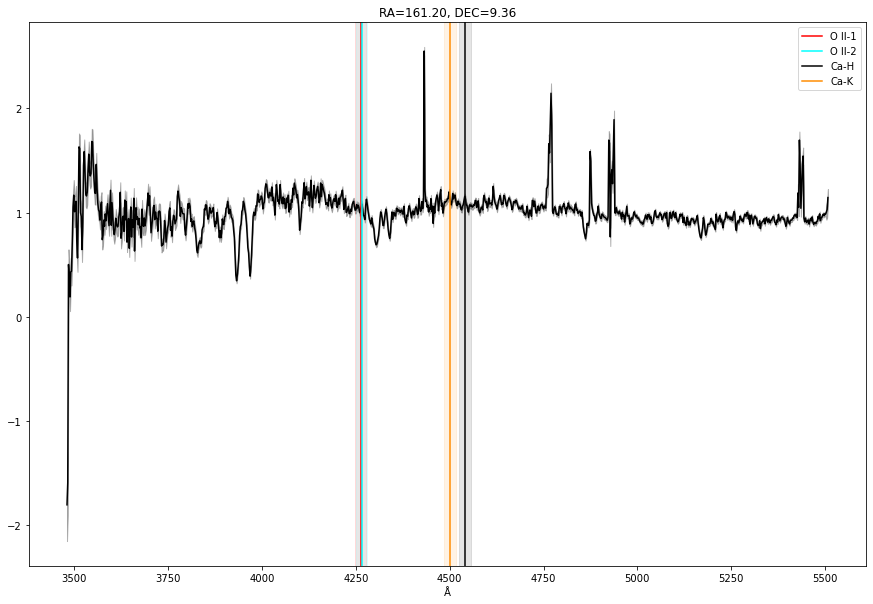

2 0


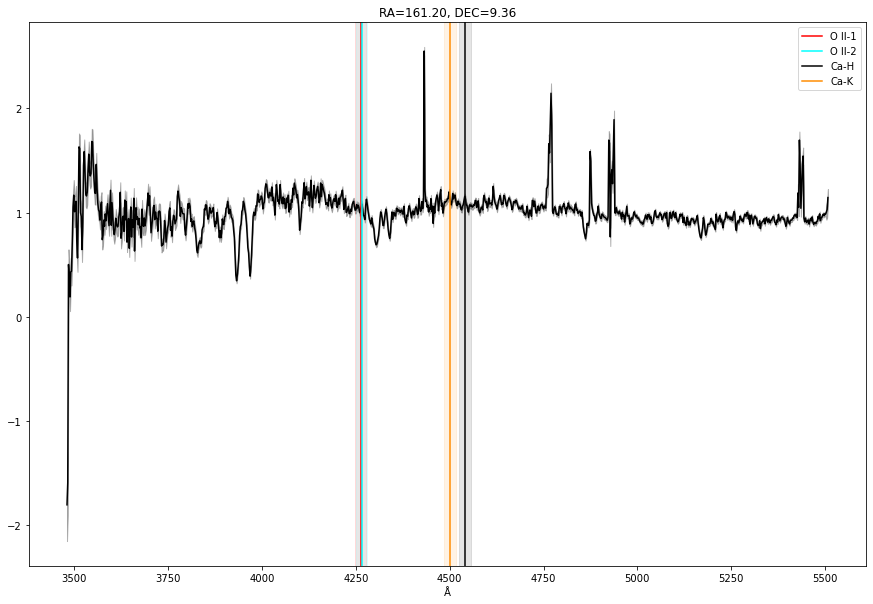

2 1


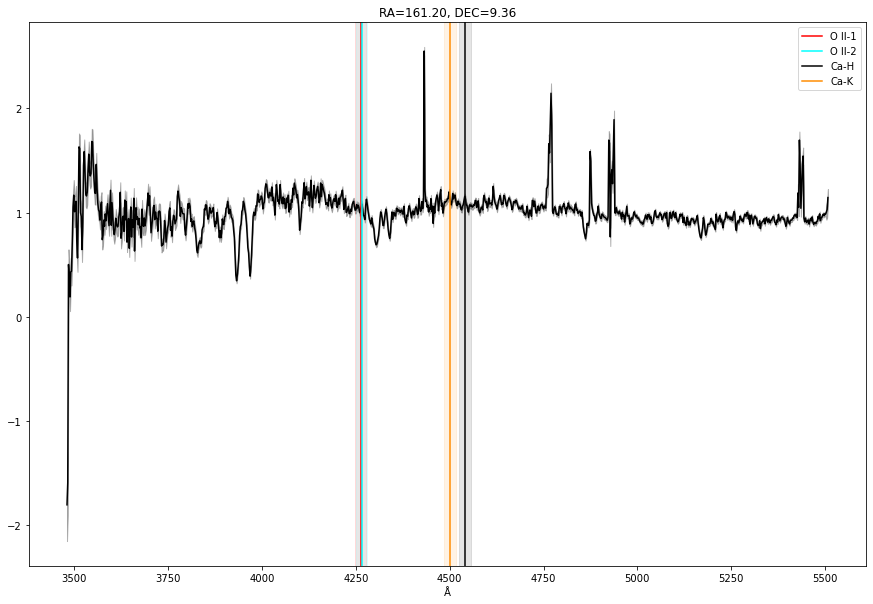

2 2


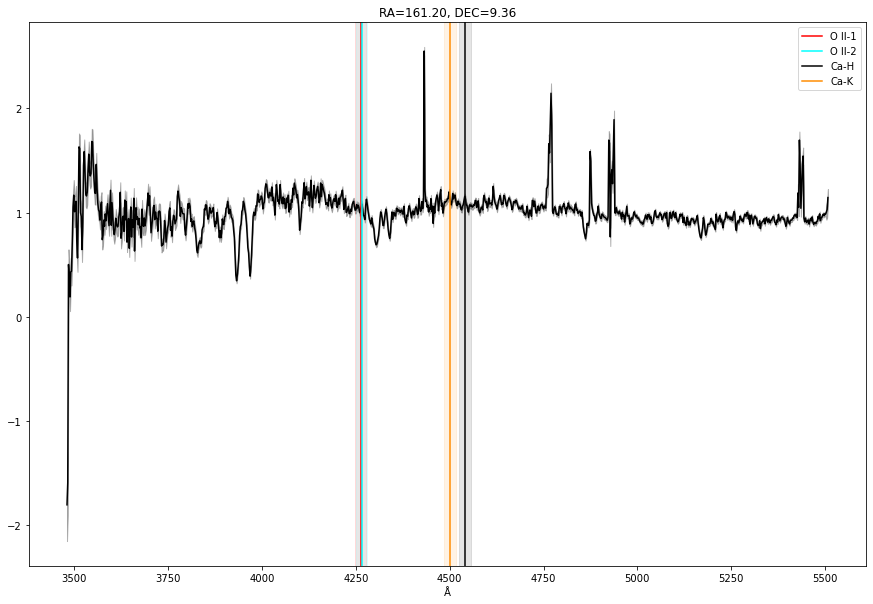

2 3


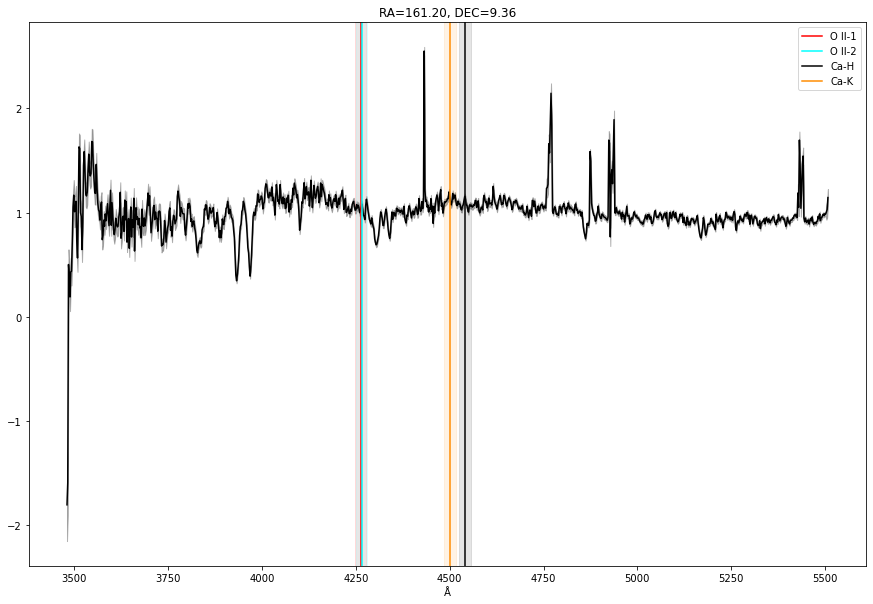

2 4


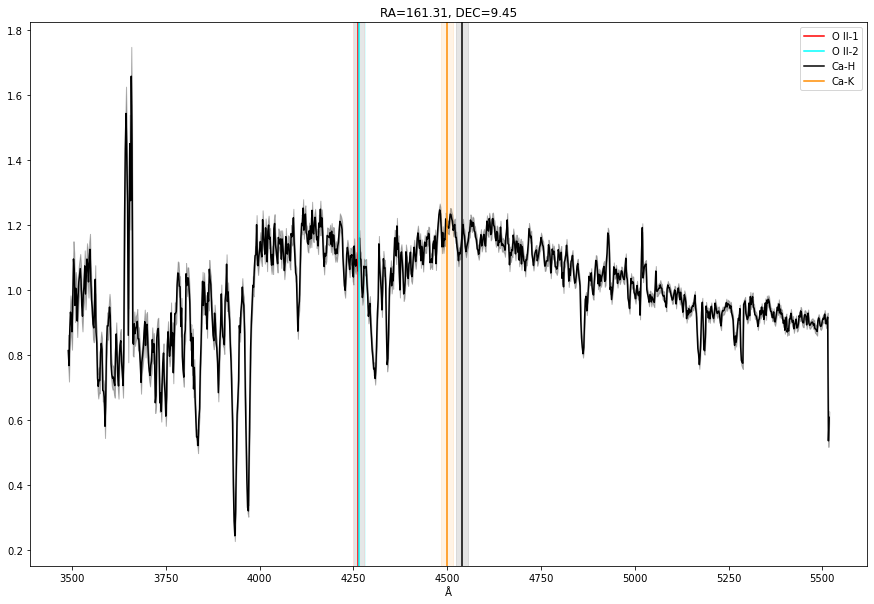

3 0


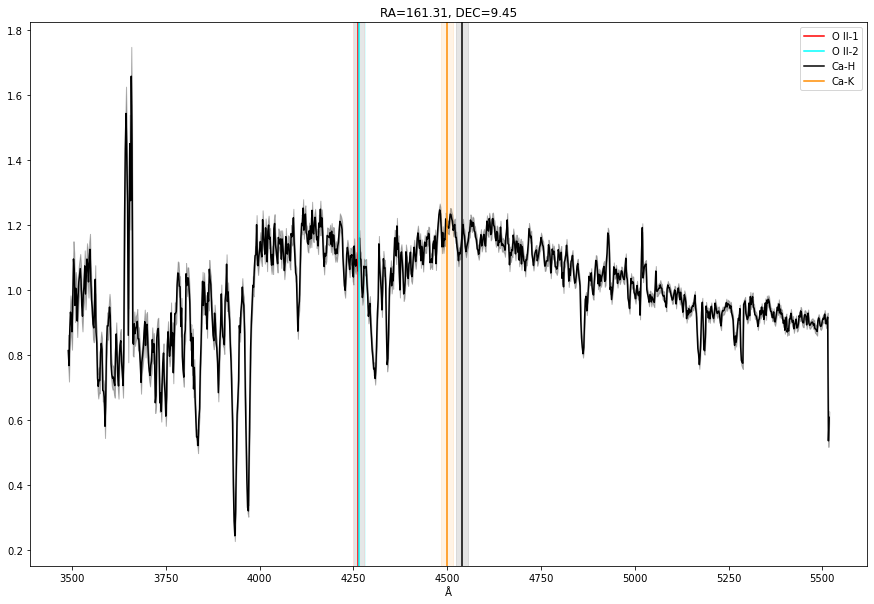

3 1


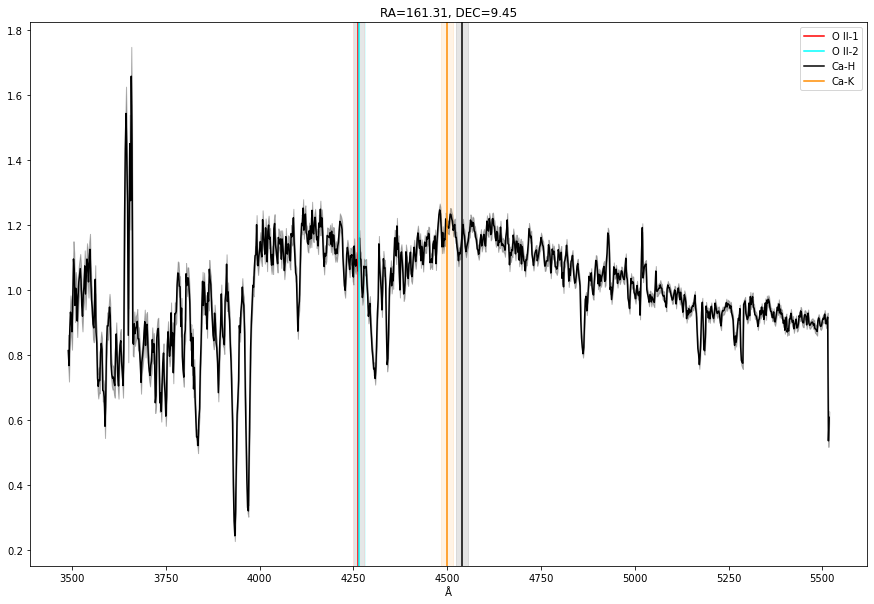

3 2


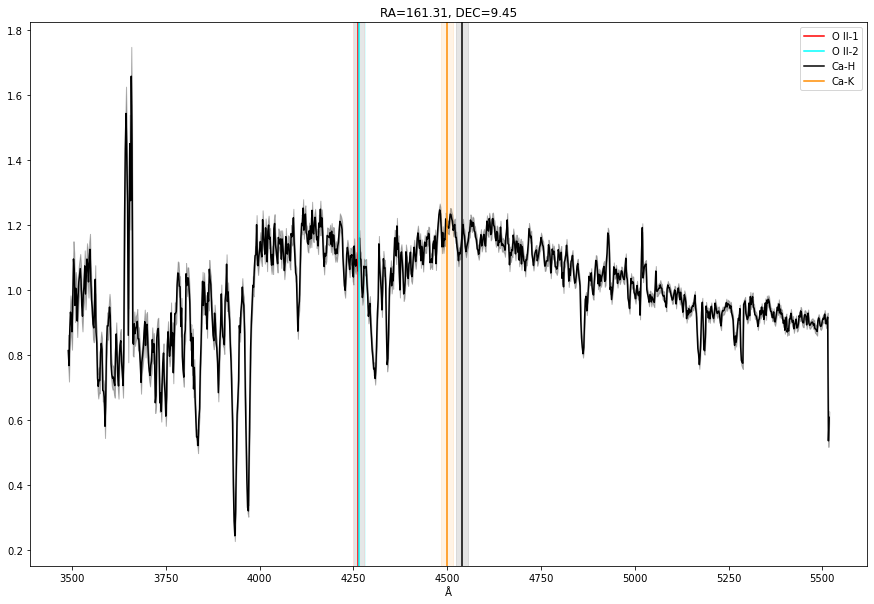

3 3


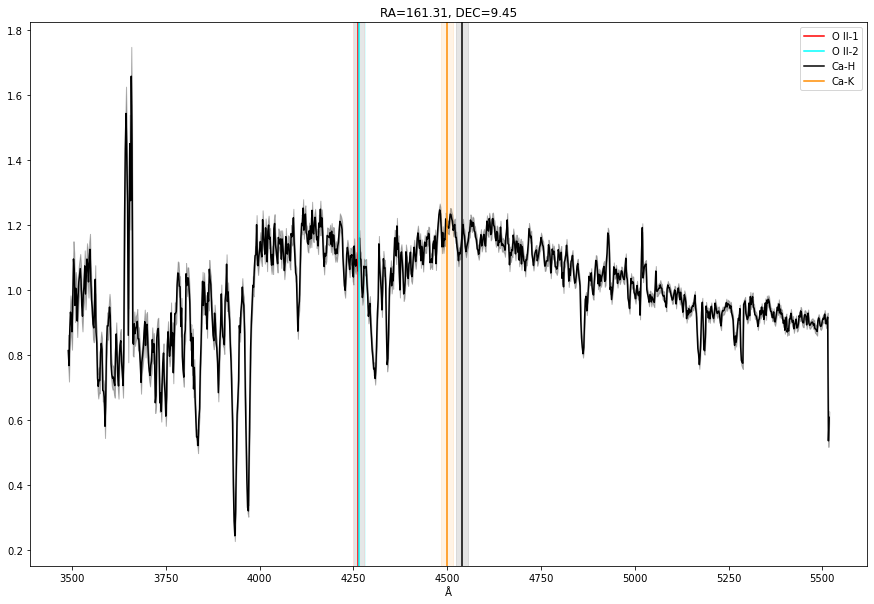

3 4


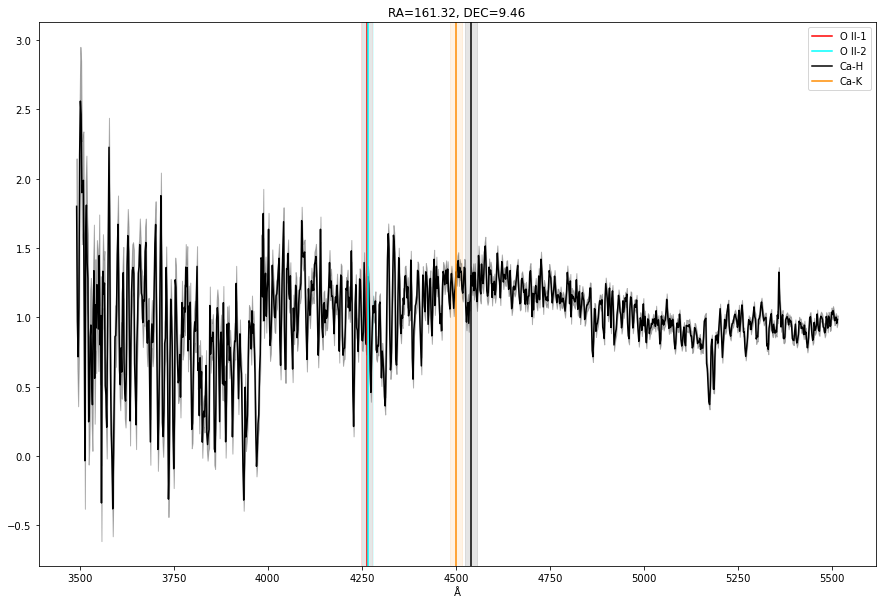

4 0


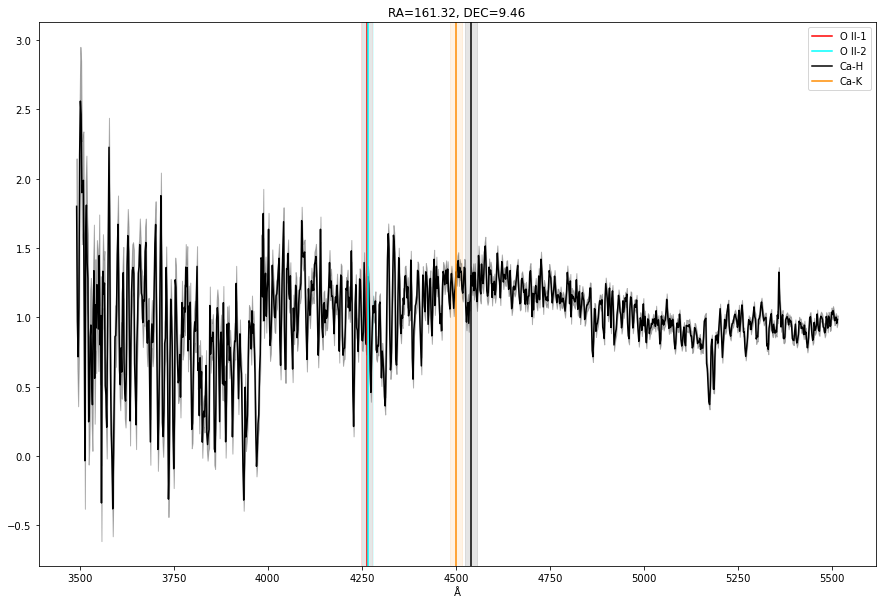

4 1


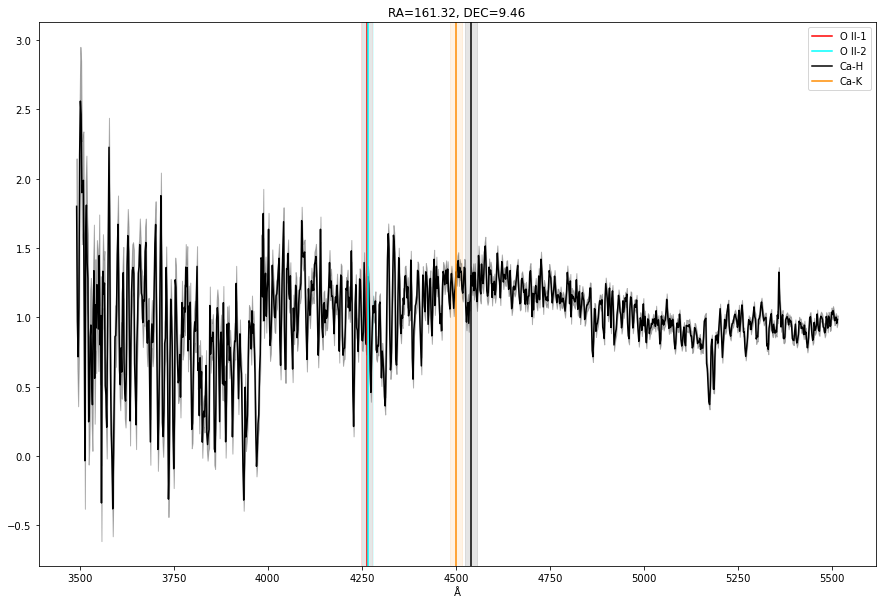

4 2


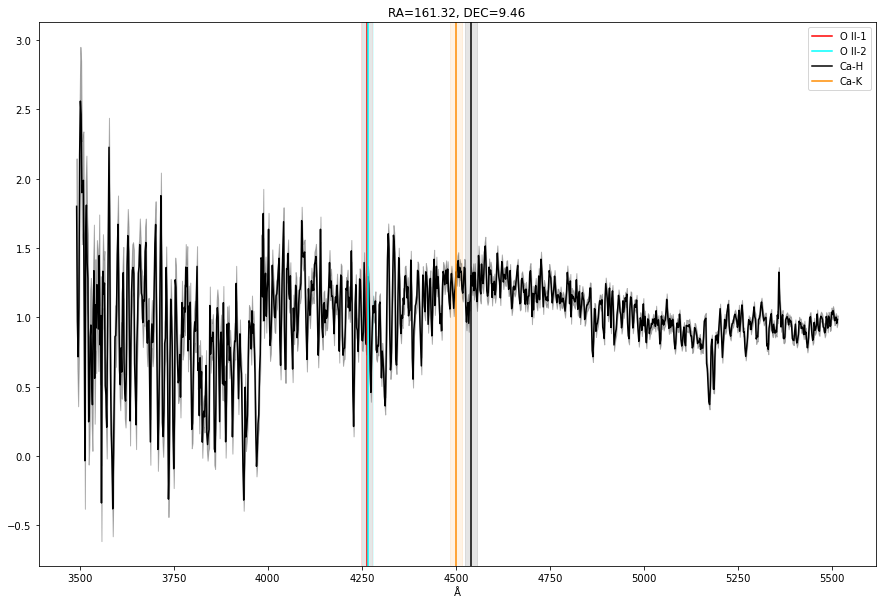

4 3


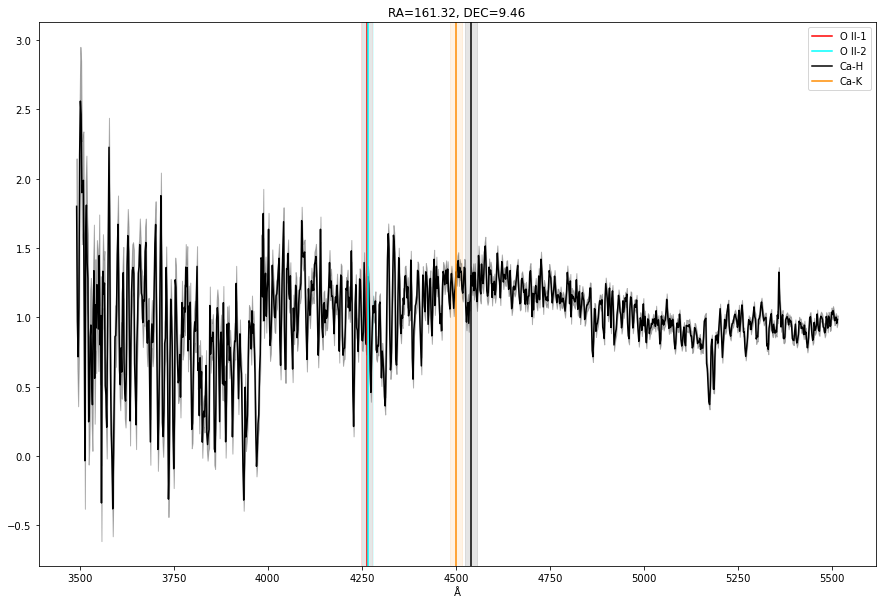

4 4


In [18]:
for i in range(5):
    for j in range(5):
        overplot(i,j)
        print(i,j)

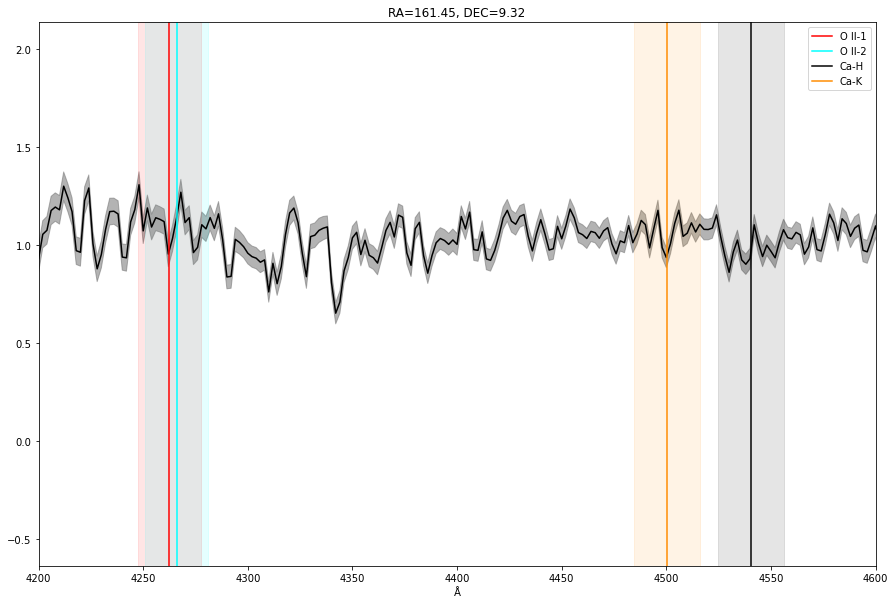

0 0


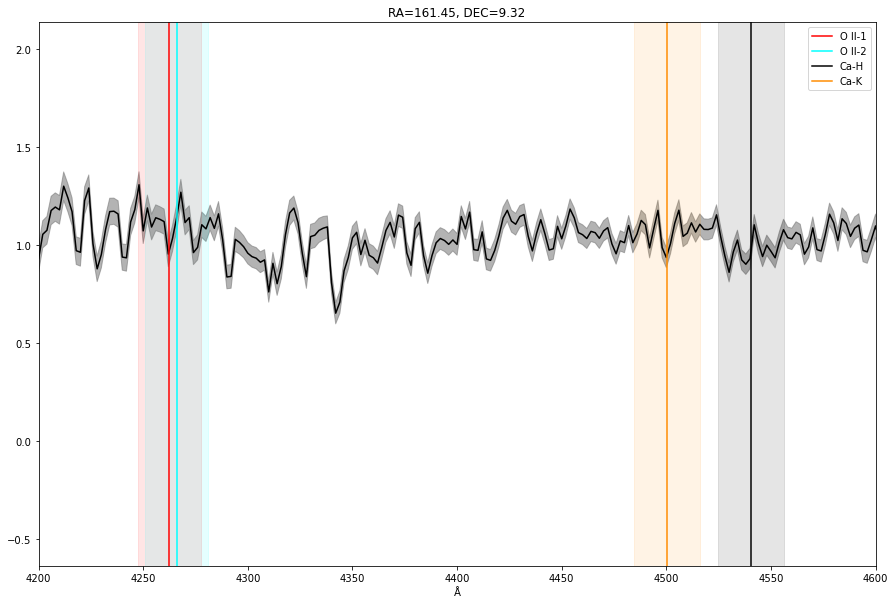

0 1


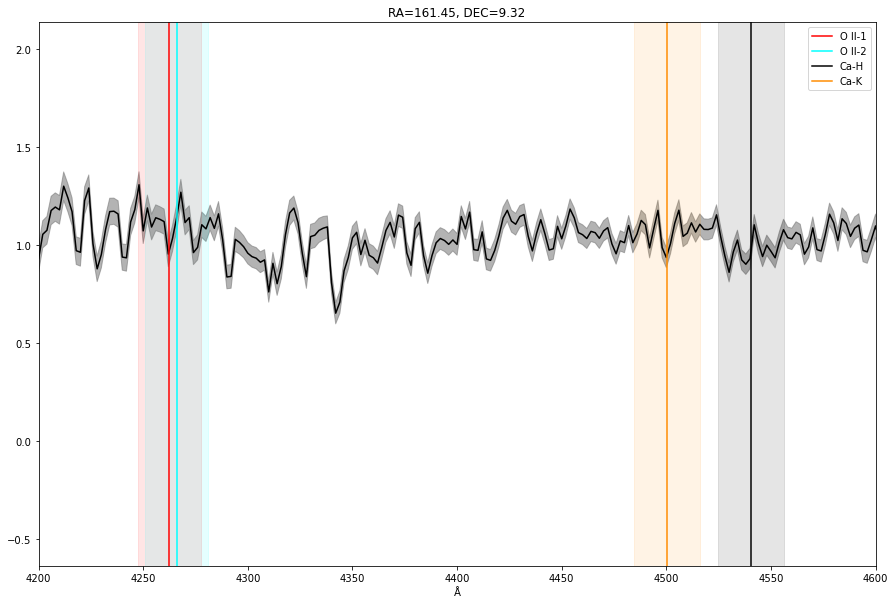

0 2


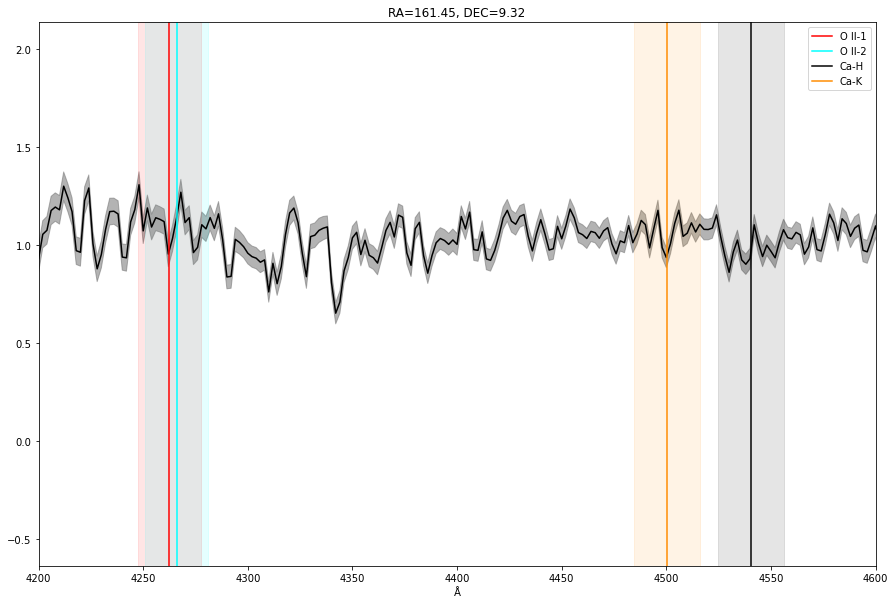

0 3


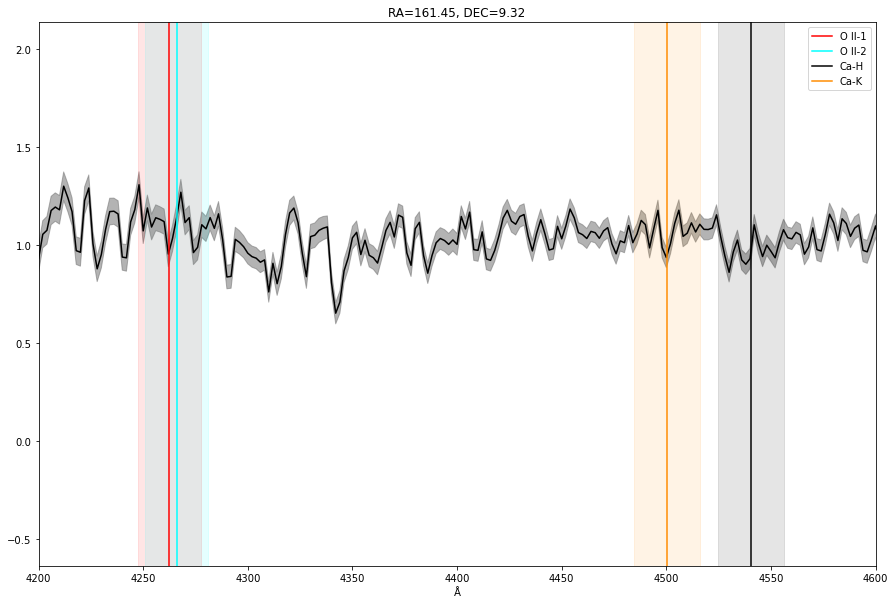

0 4


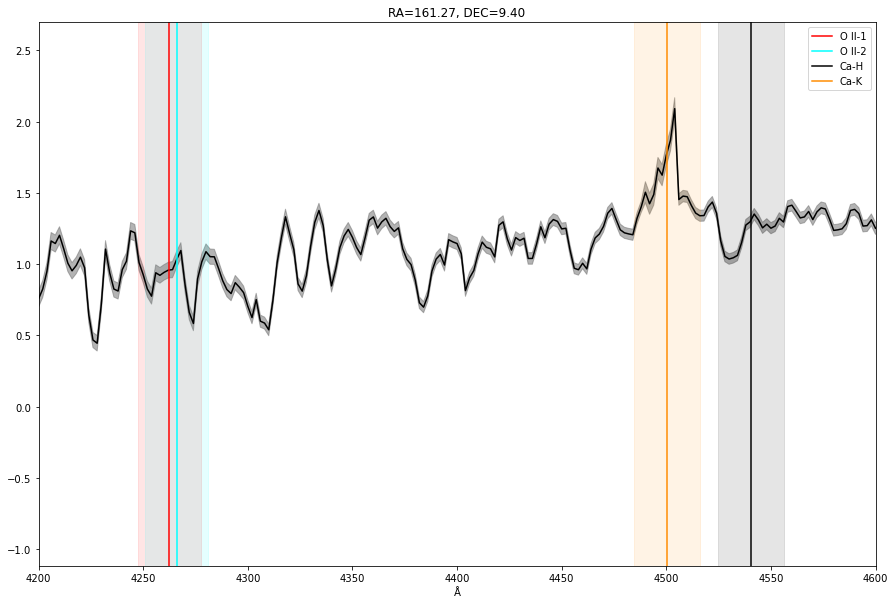

1 0


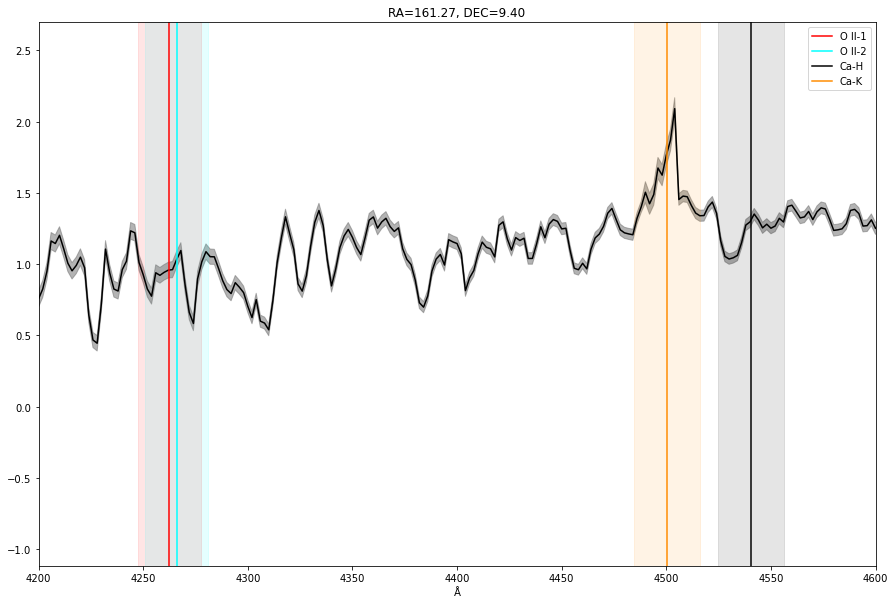

1 1


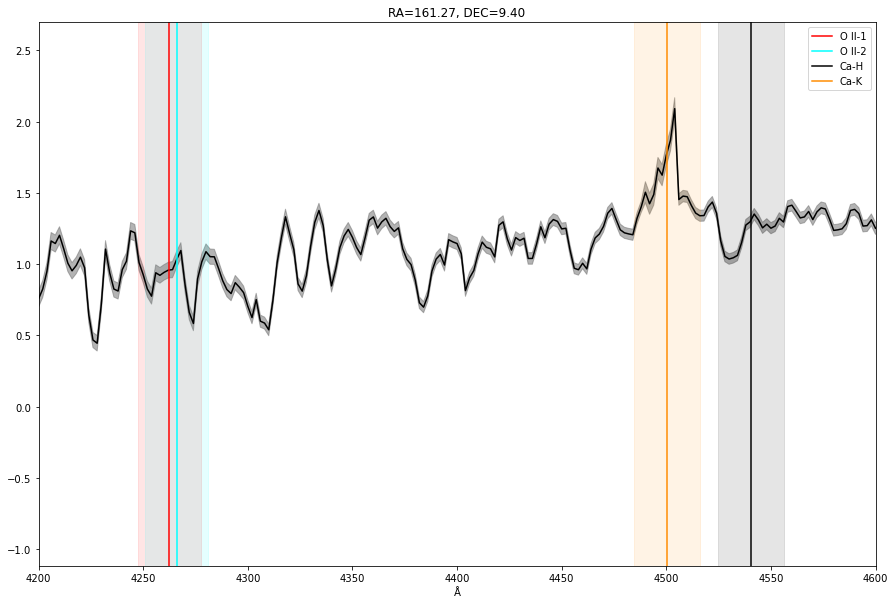

1 2


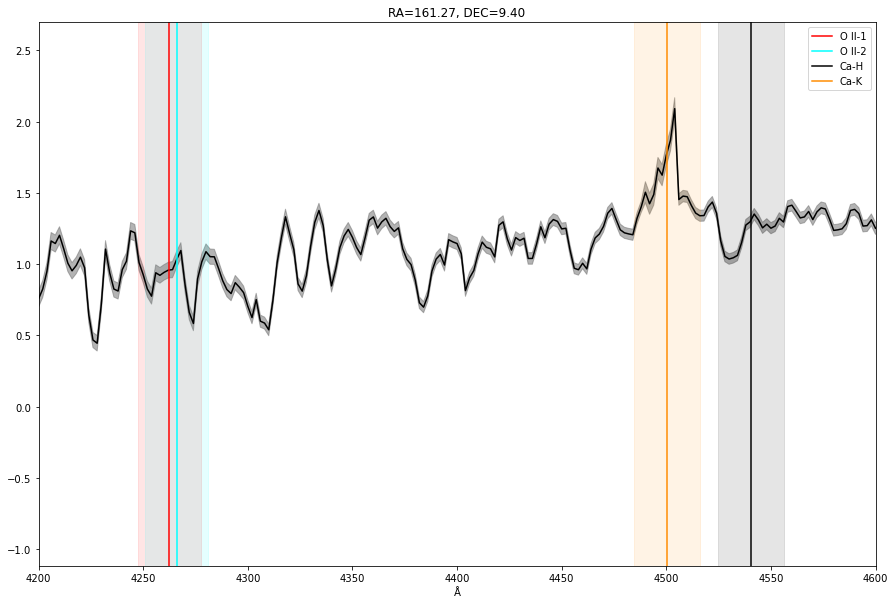

1 3


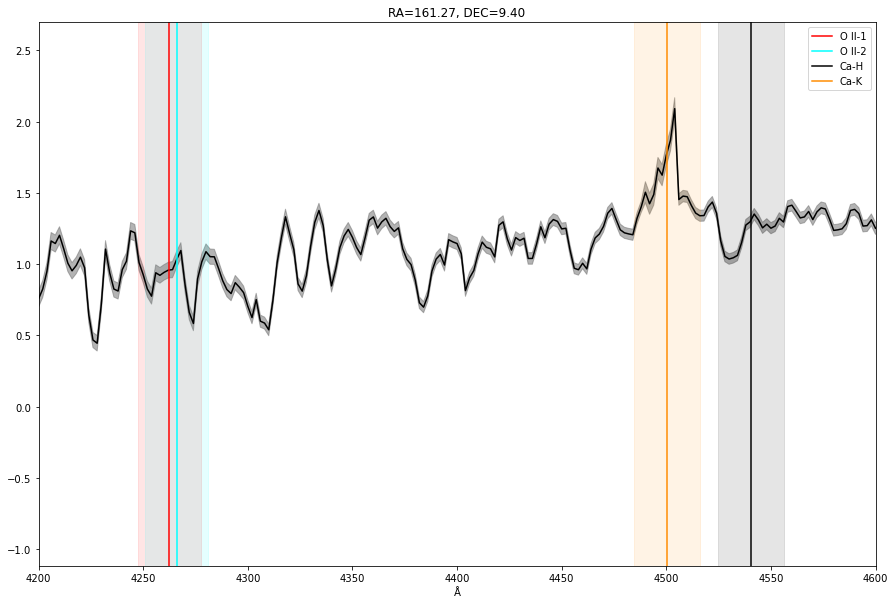

1 4


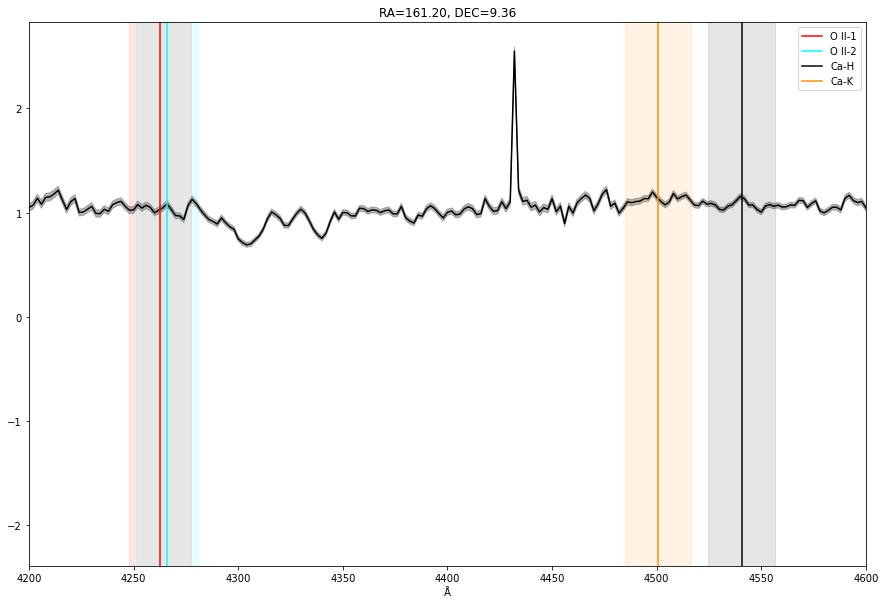

2 0


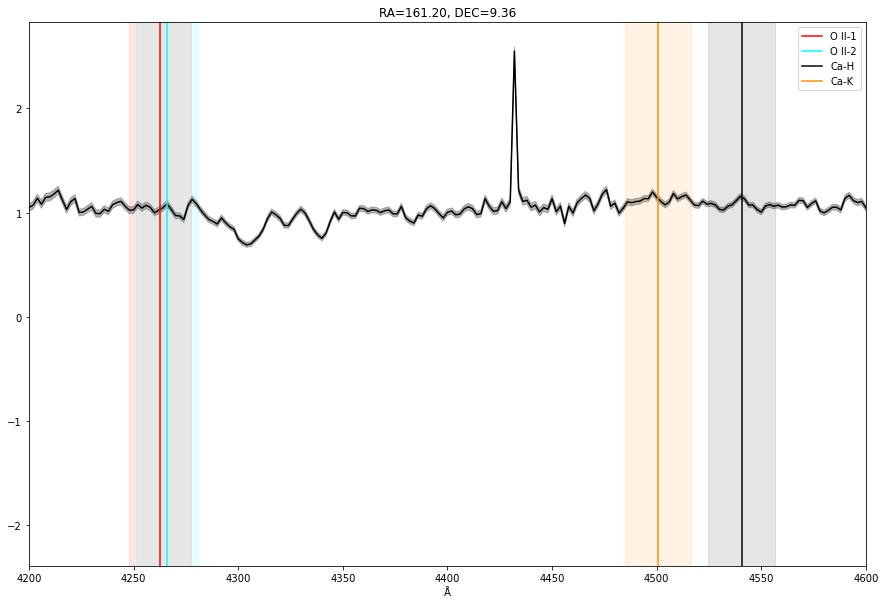

2 1


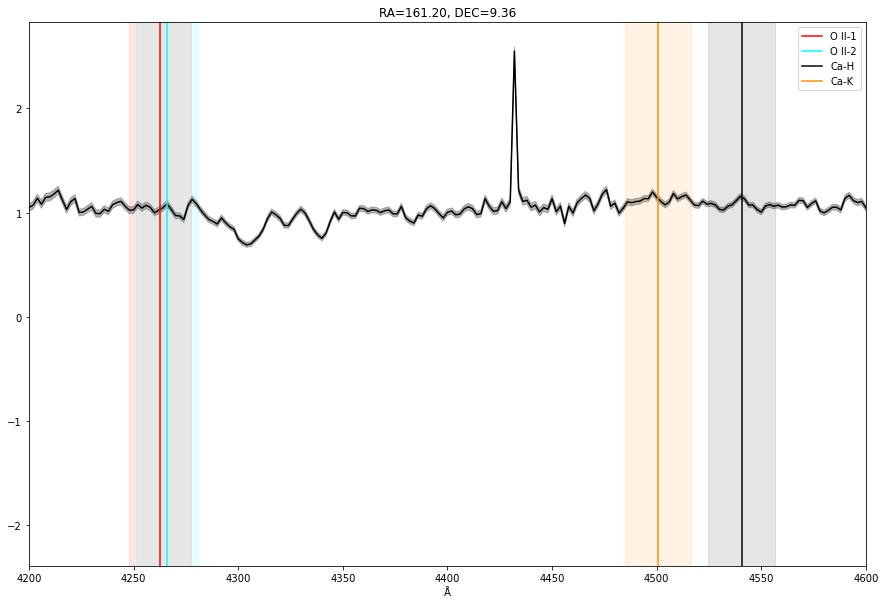

2 2


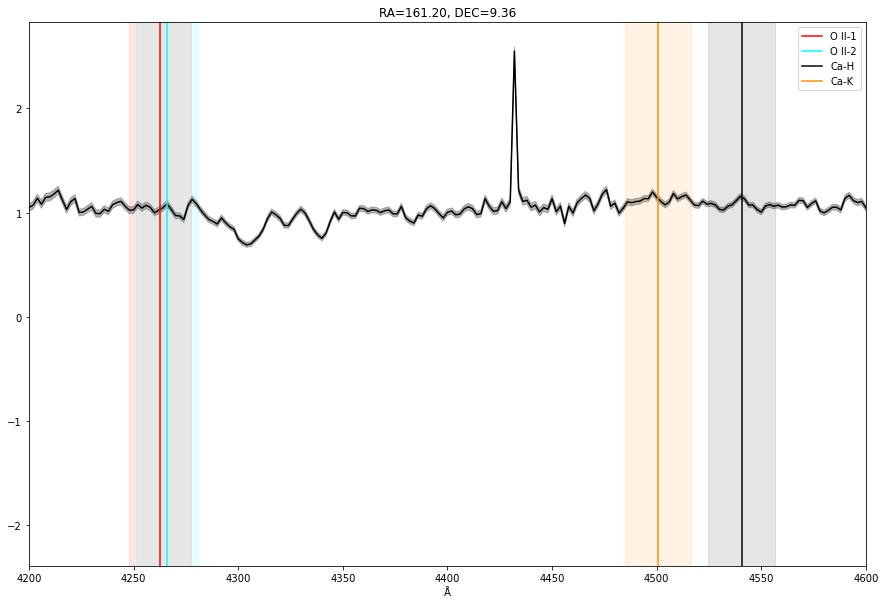

2 3


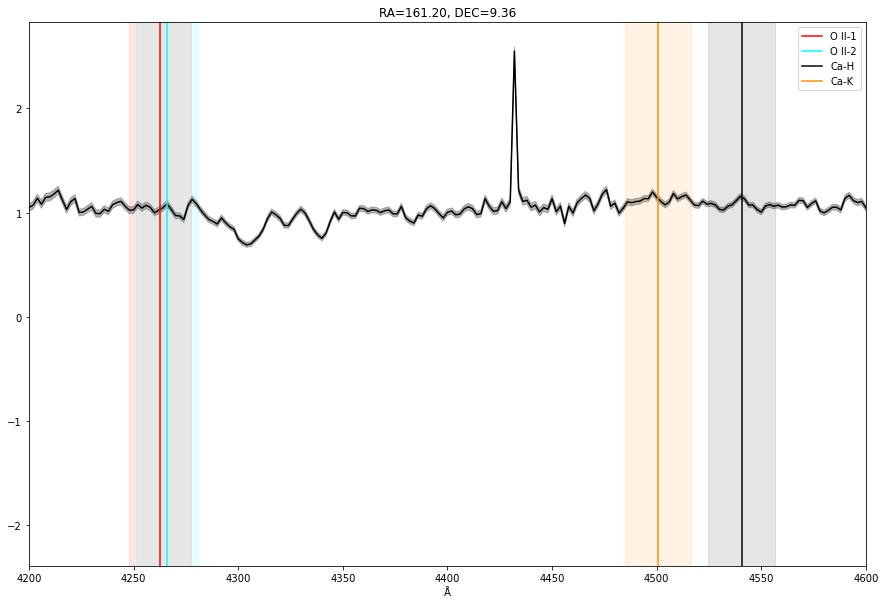

2 4


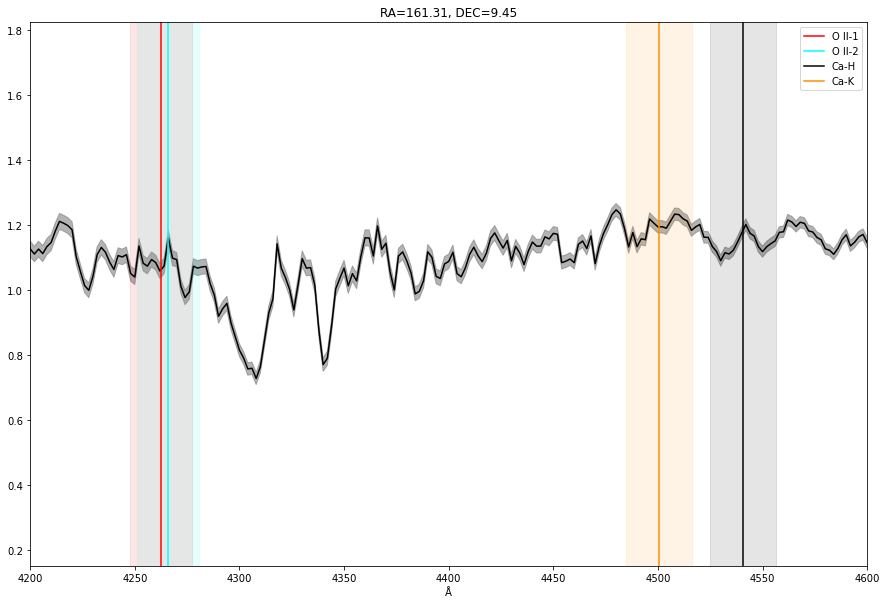

3 0


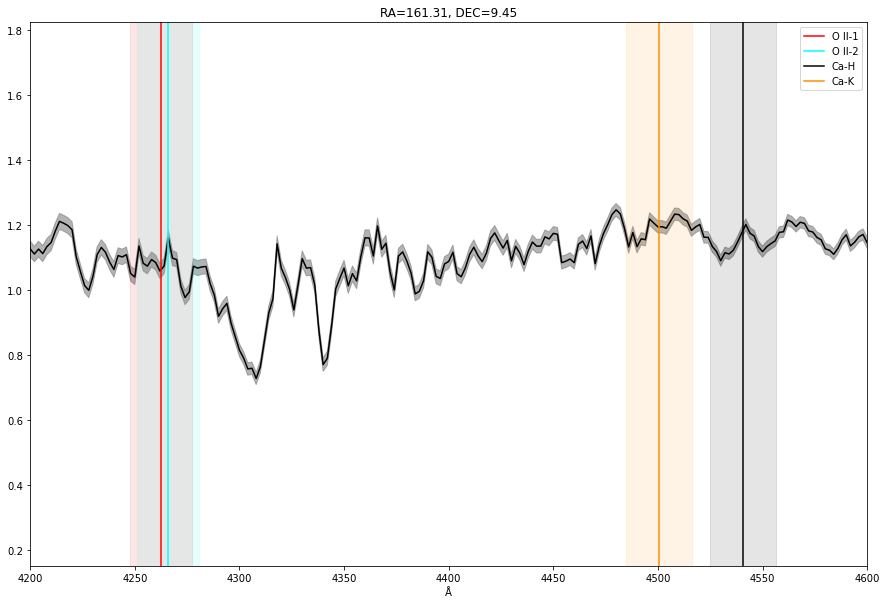

3 1


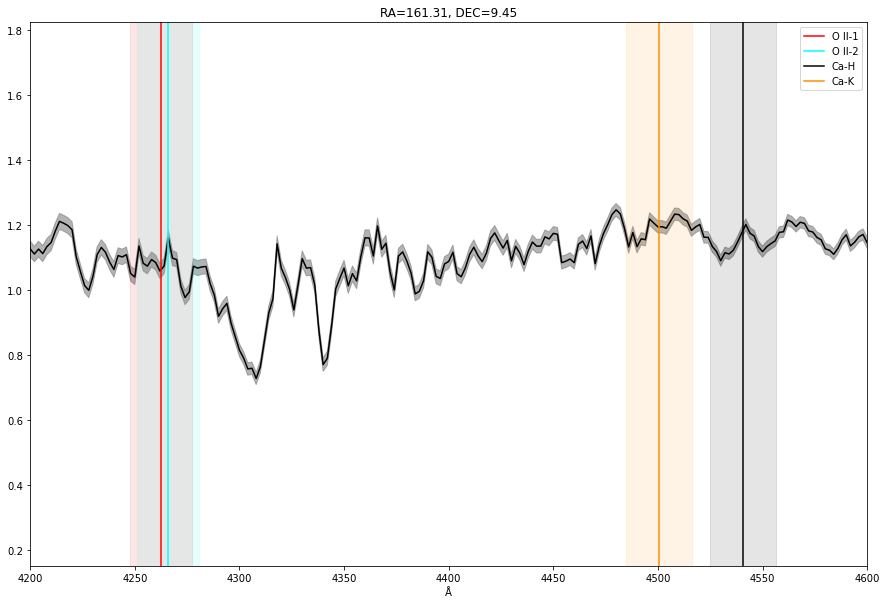

3 2


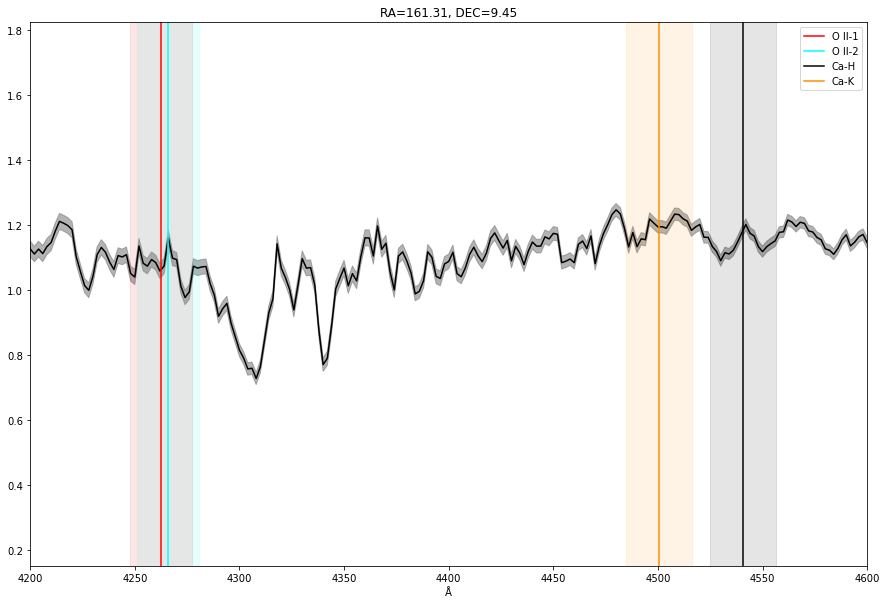

3 3


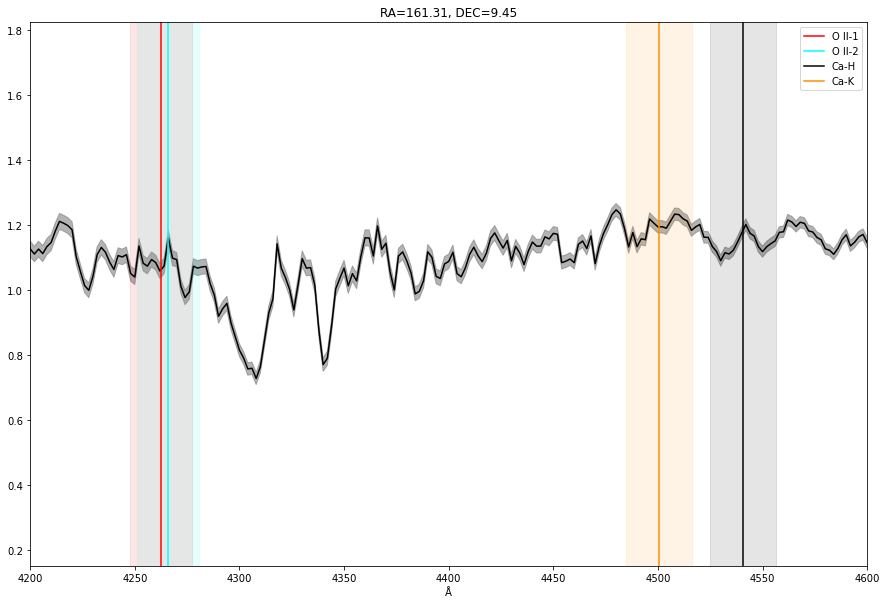

3 4


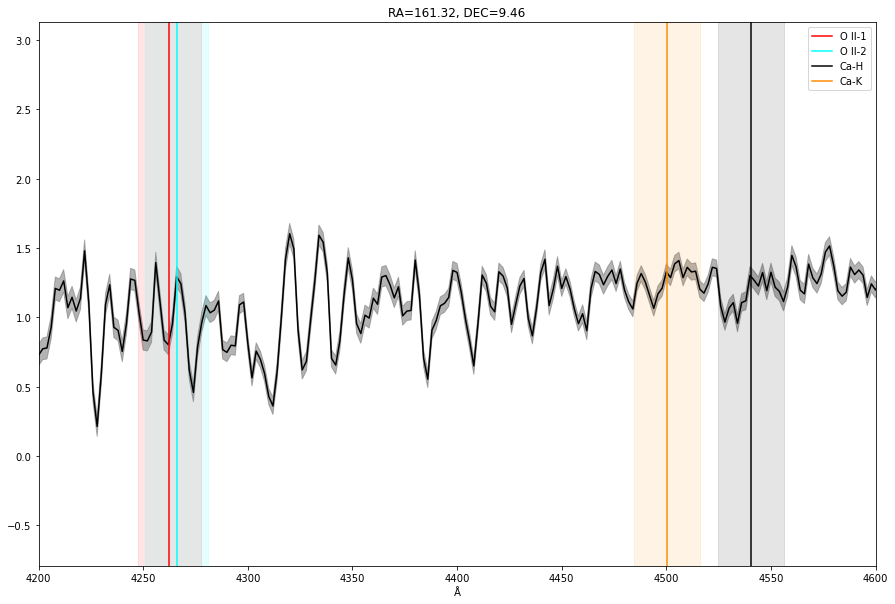

4 0


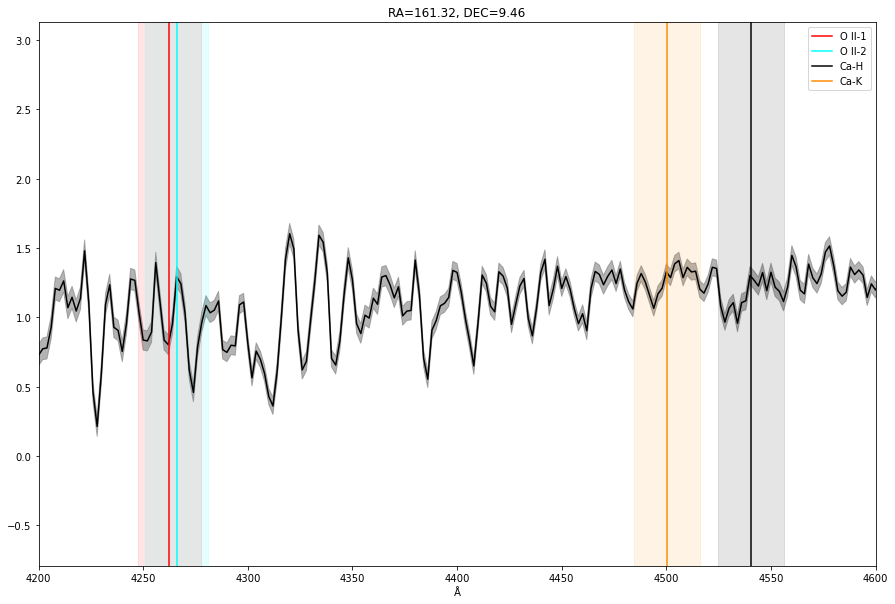

4 1


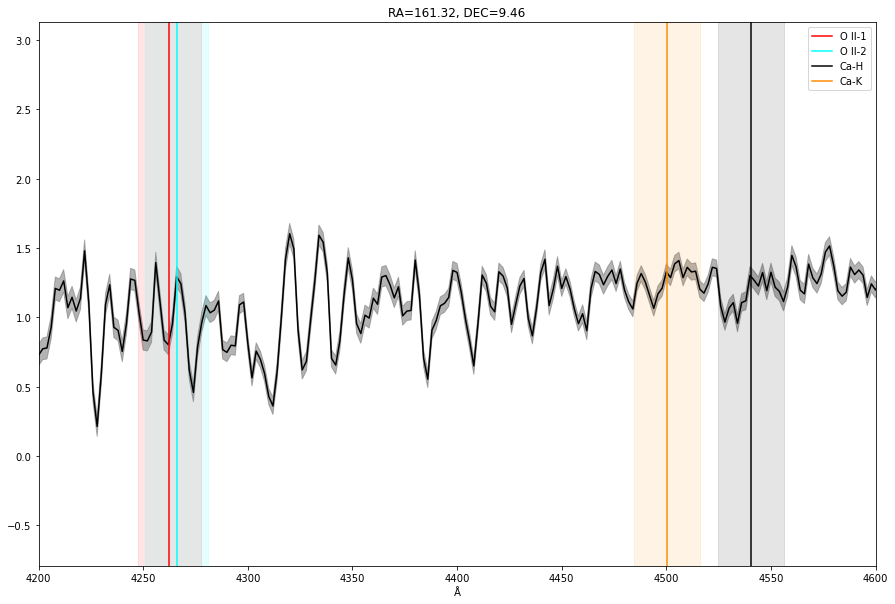

4 2


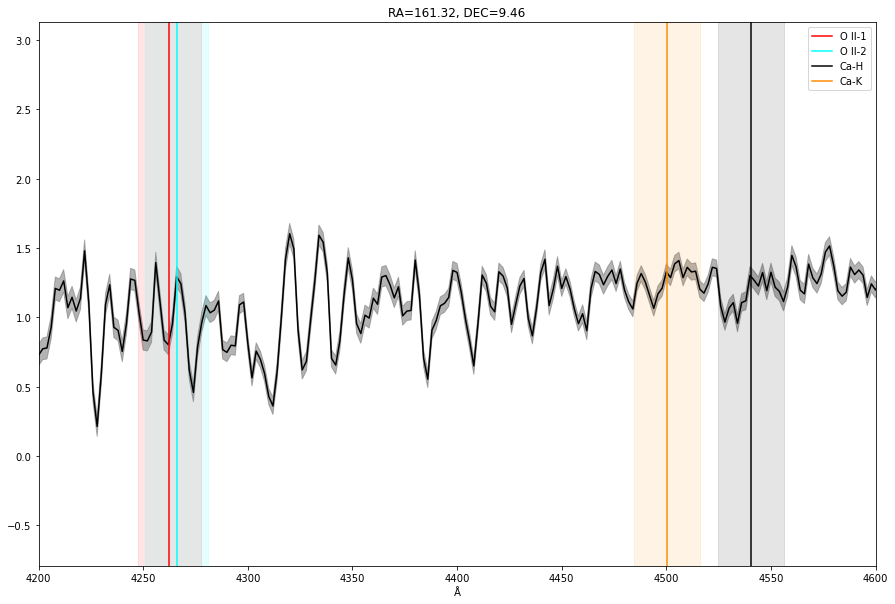

4 3


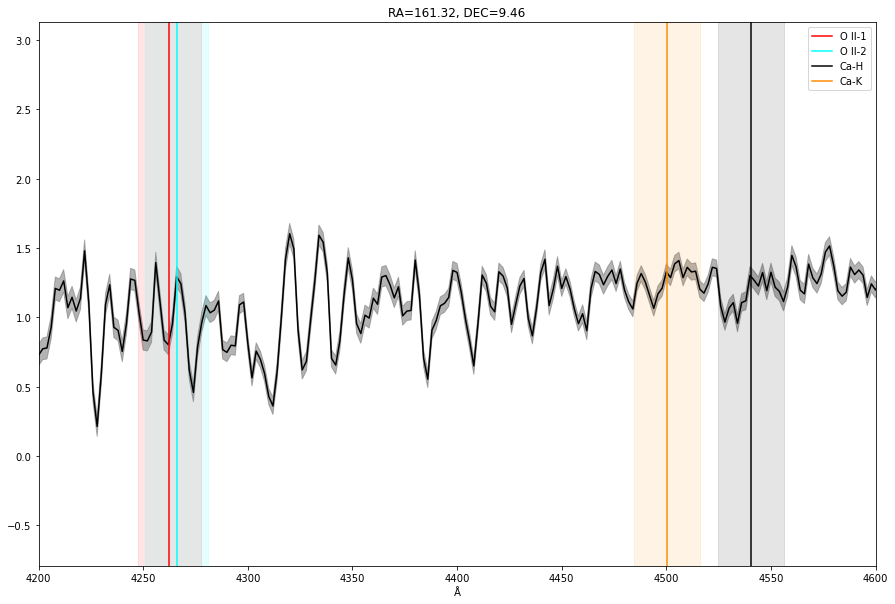

4 4


In [17]:
for i in range(5):
    for j in range(5):
        overplot(i,j,zoom1=4200,zoom2=4600)
        print(i,j)

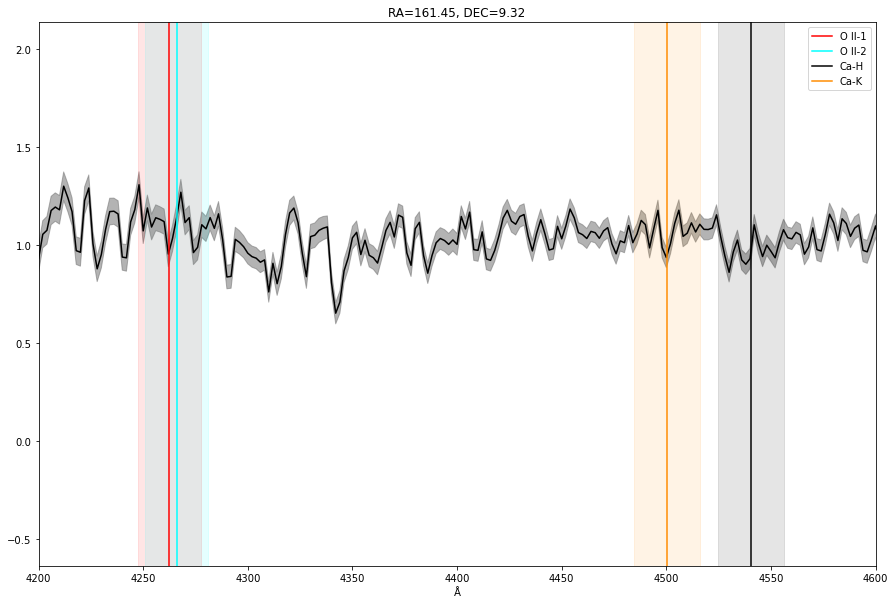

0 0


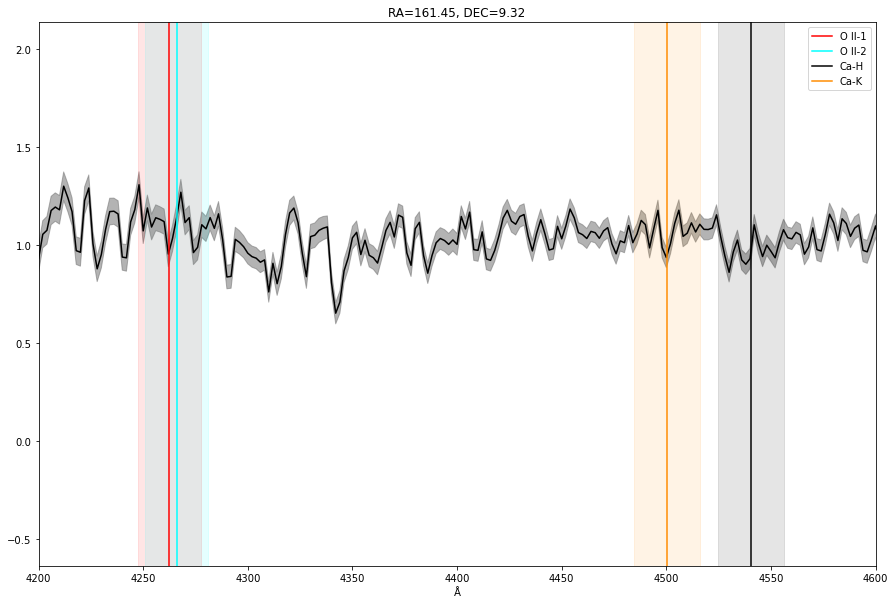

0 1


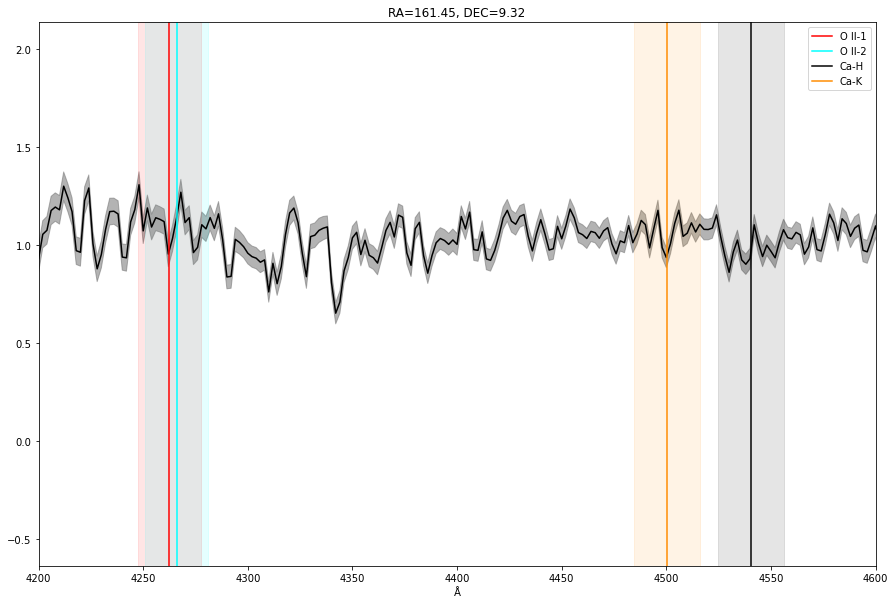

0 2


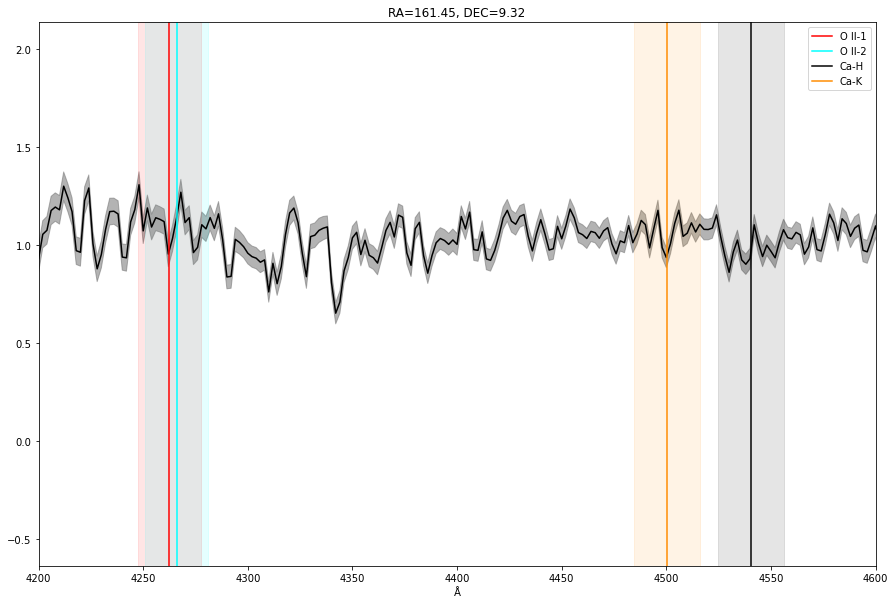

0 3


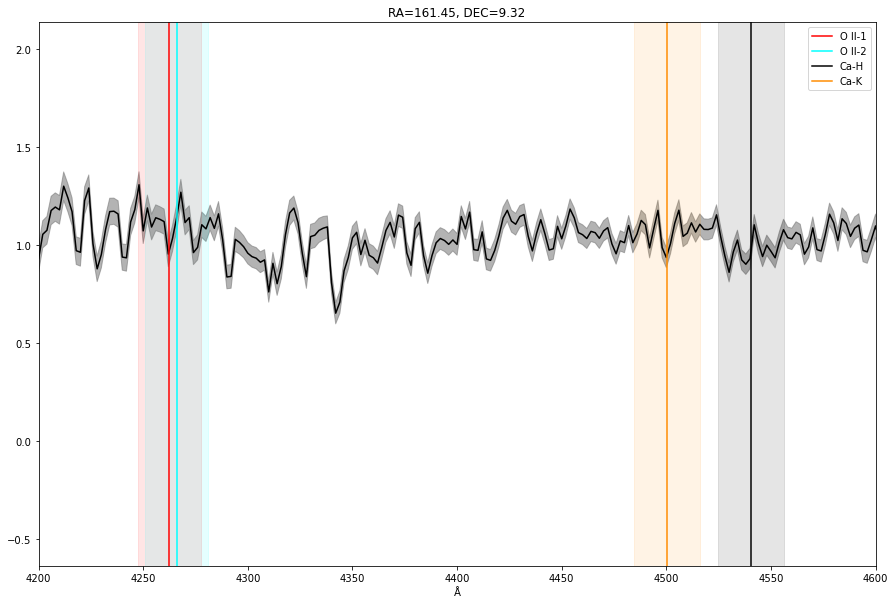

0 4


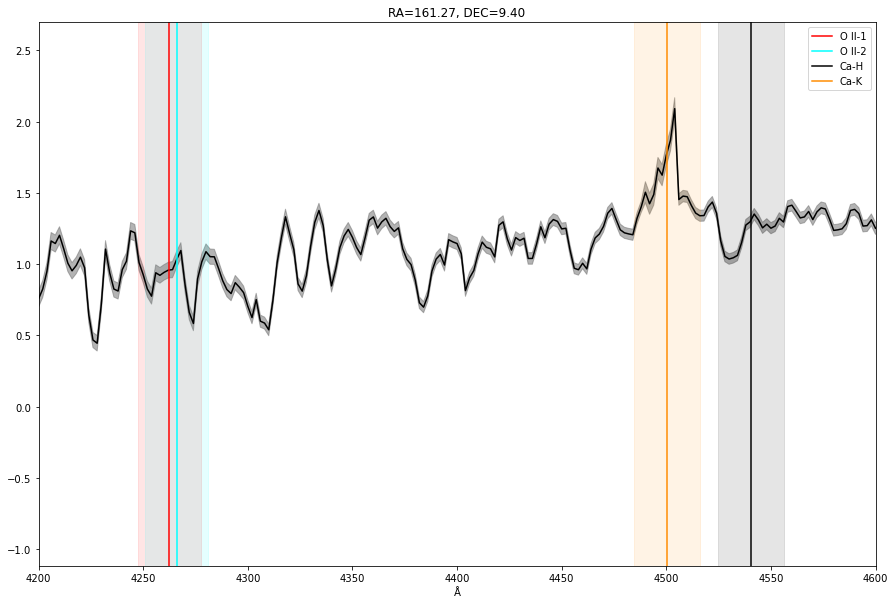

1 0


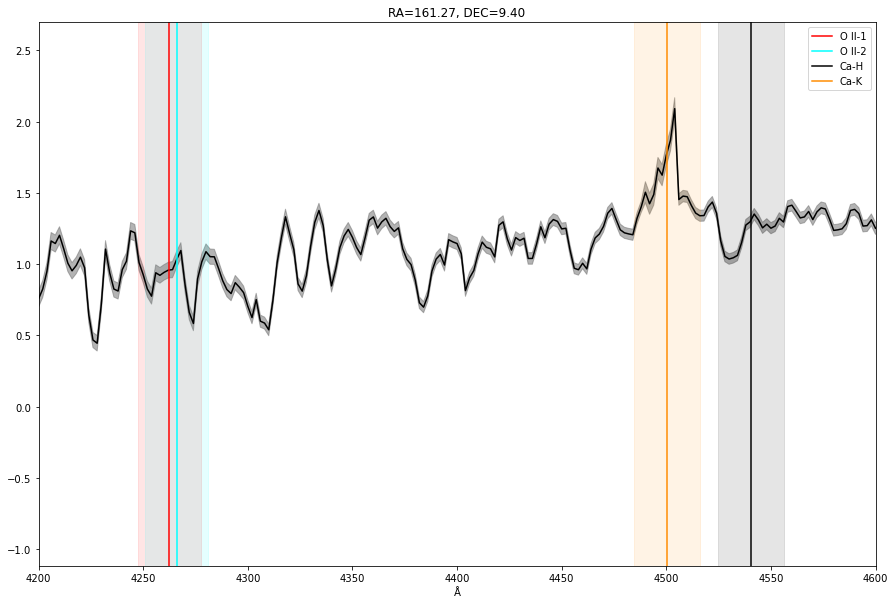

1 1


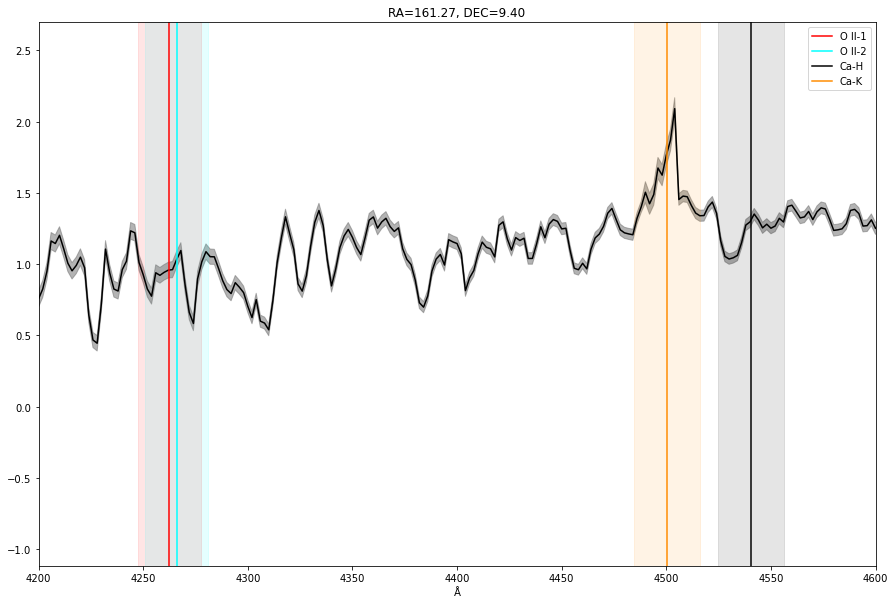

1 2


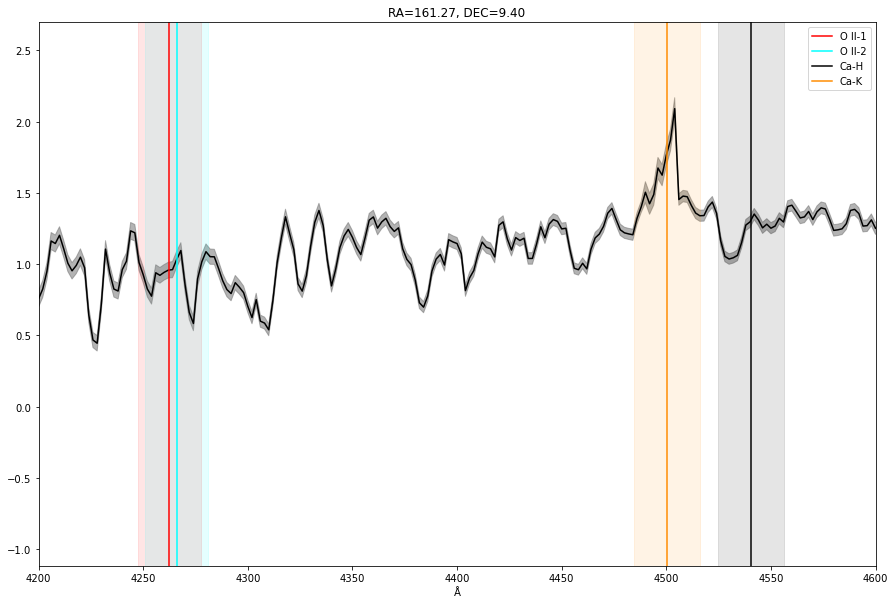

1 3


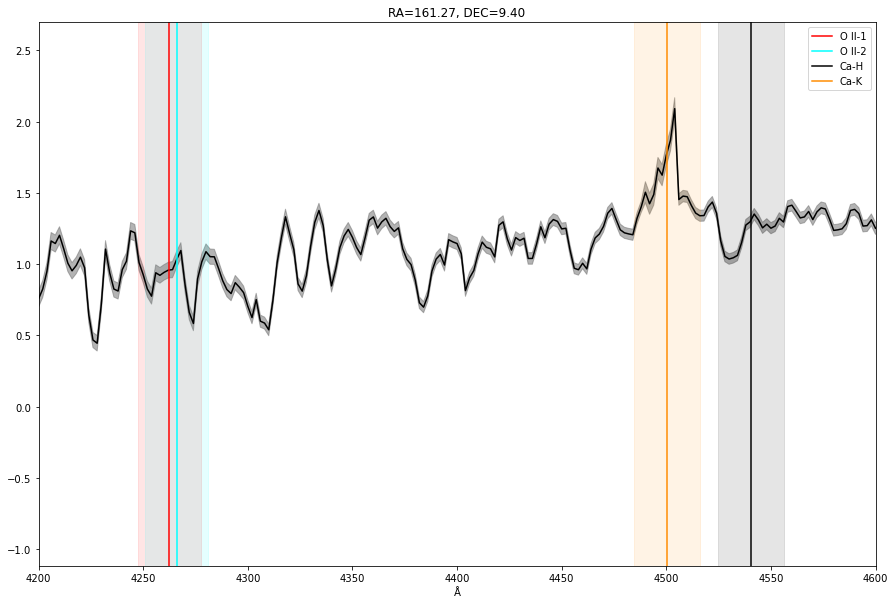

1 4


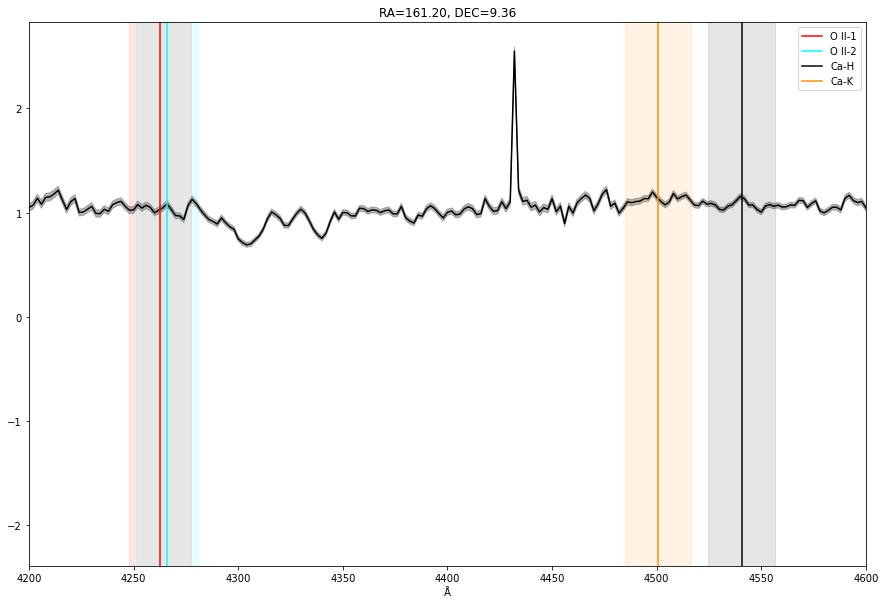

2 0


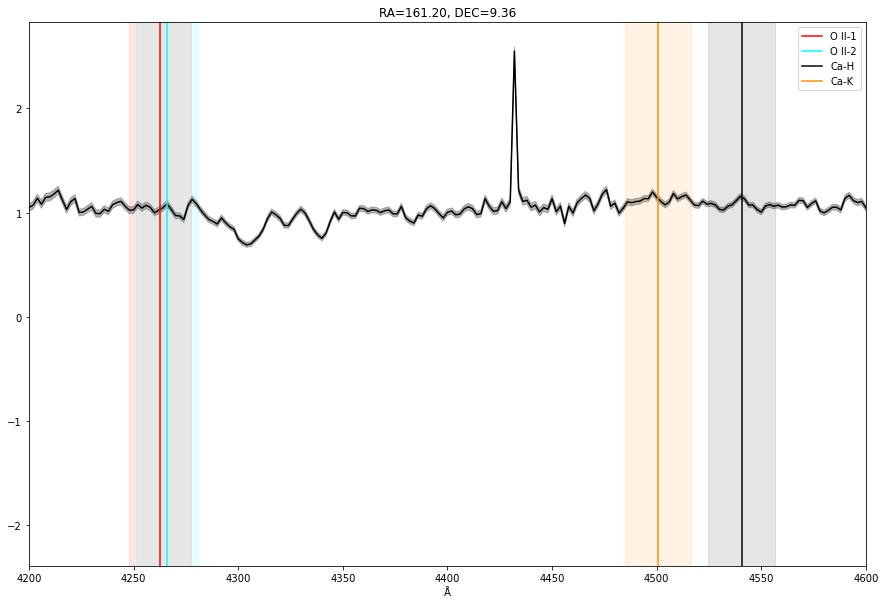

2 1


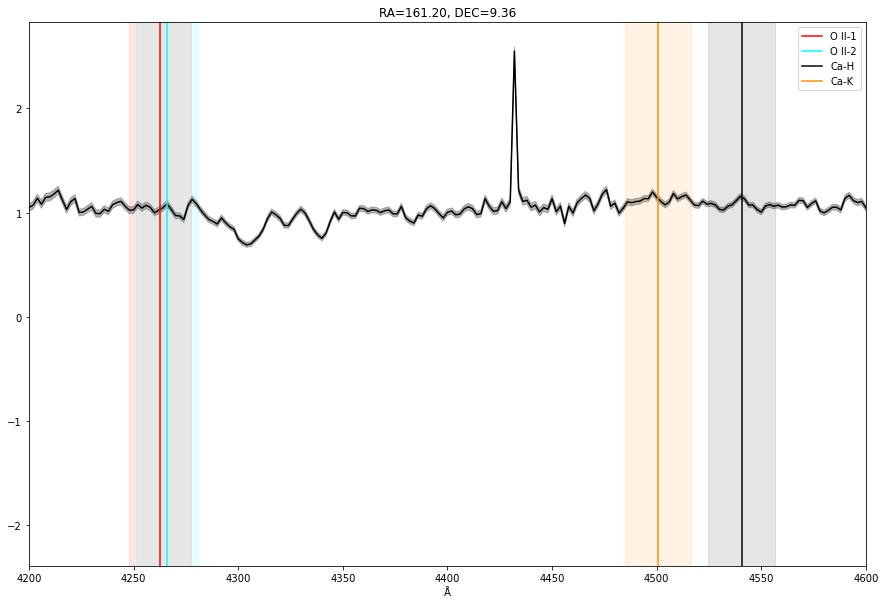

2 2


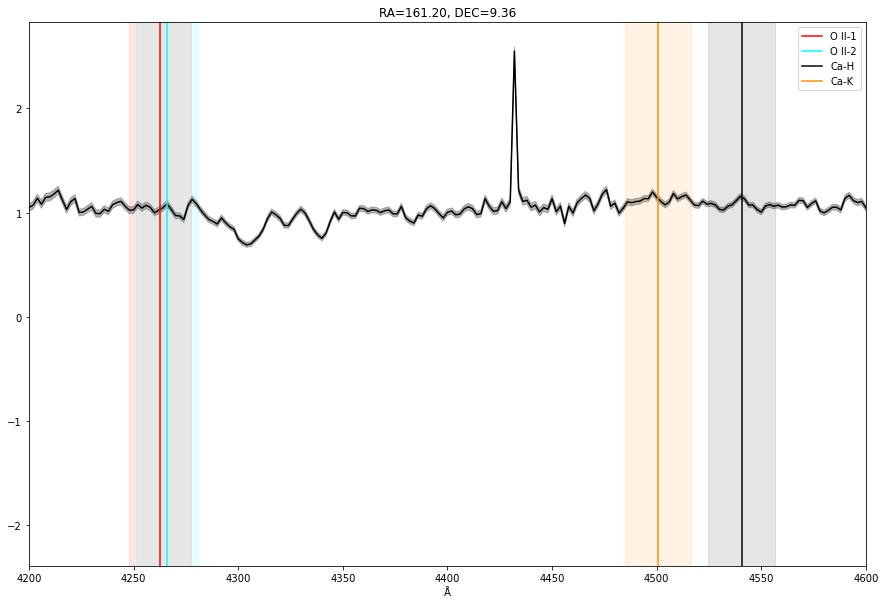

2 3


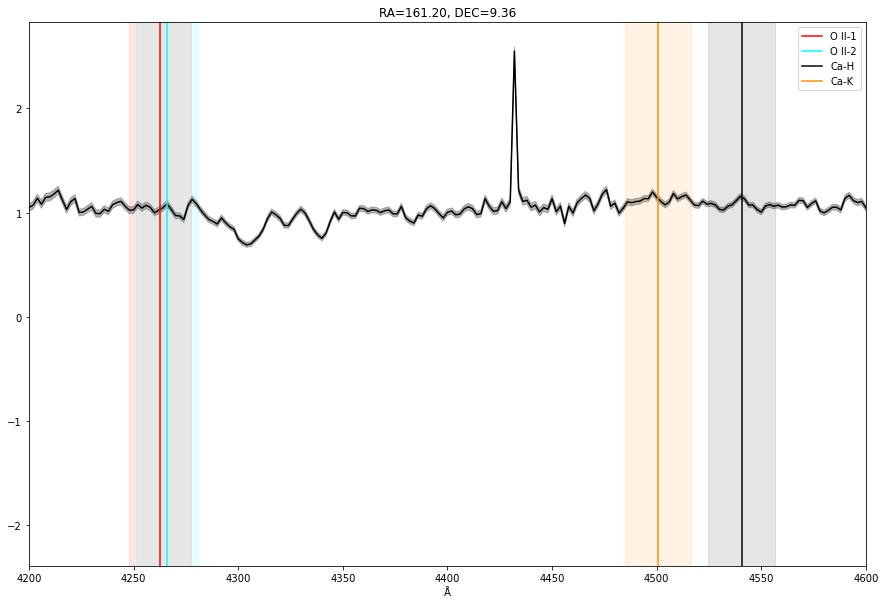

2 4


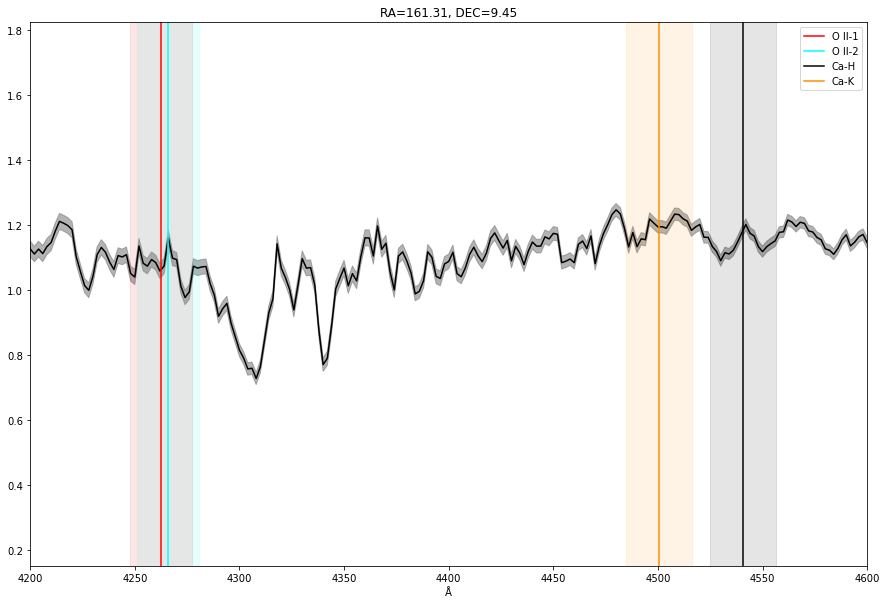

3 0


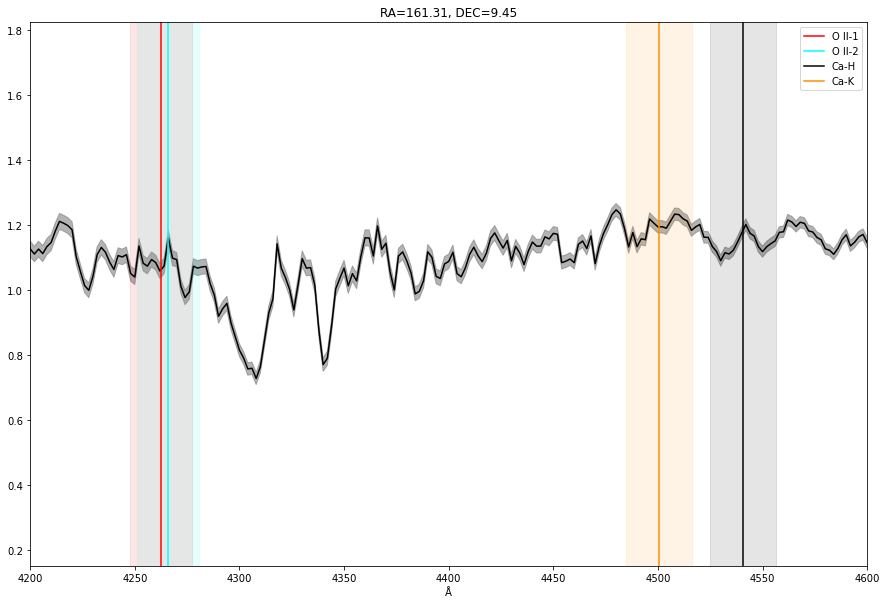

3 1


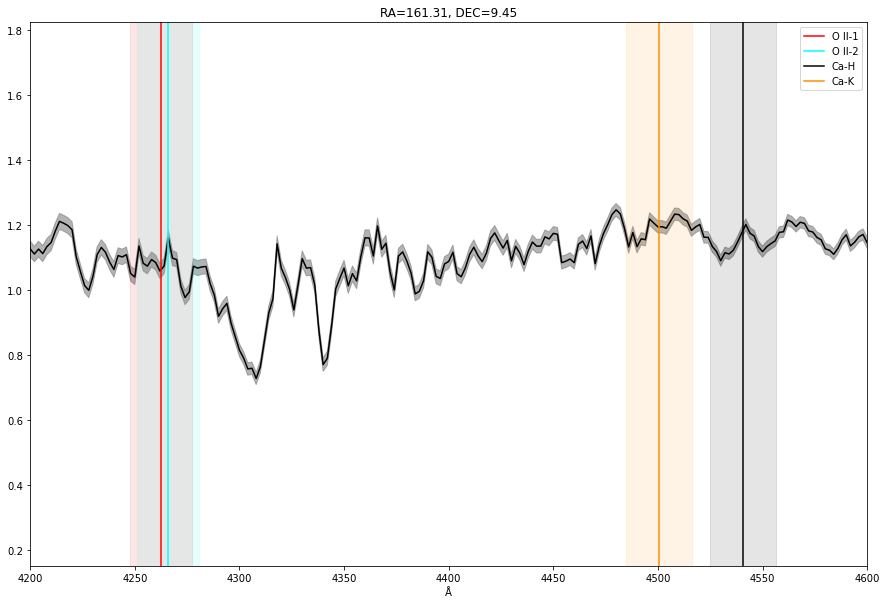

3 2


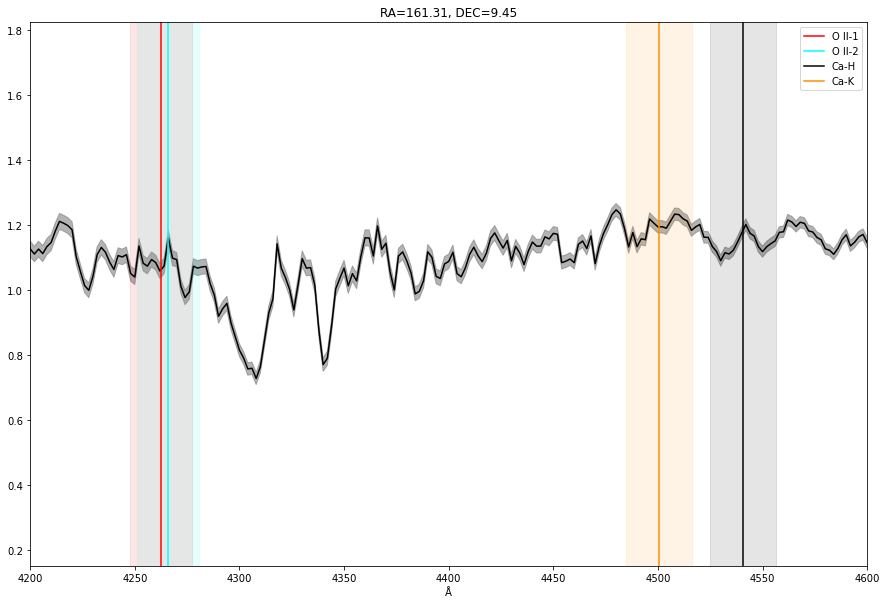

3 3


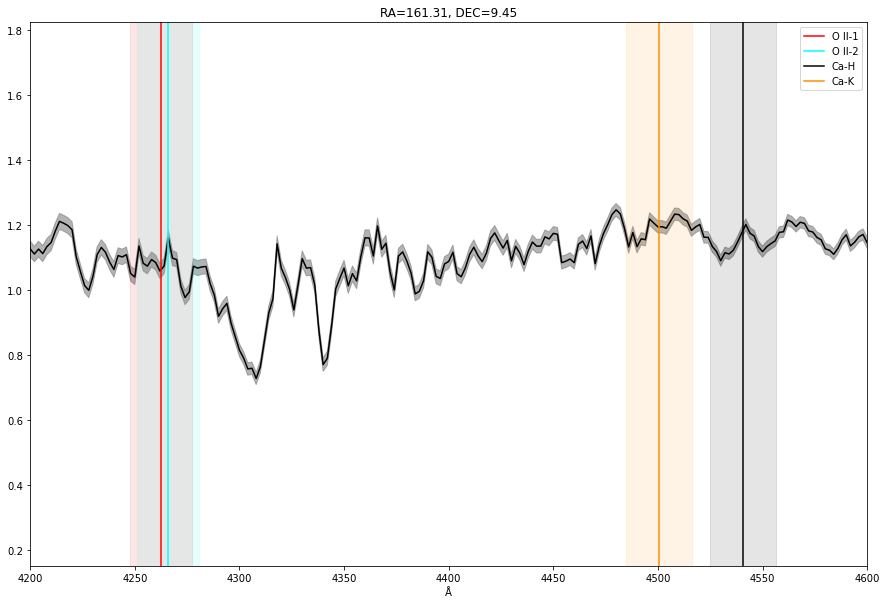

3 4


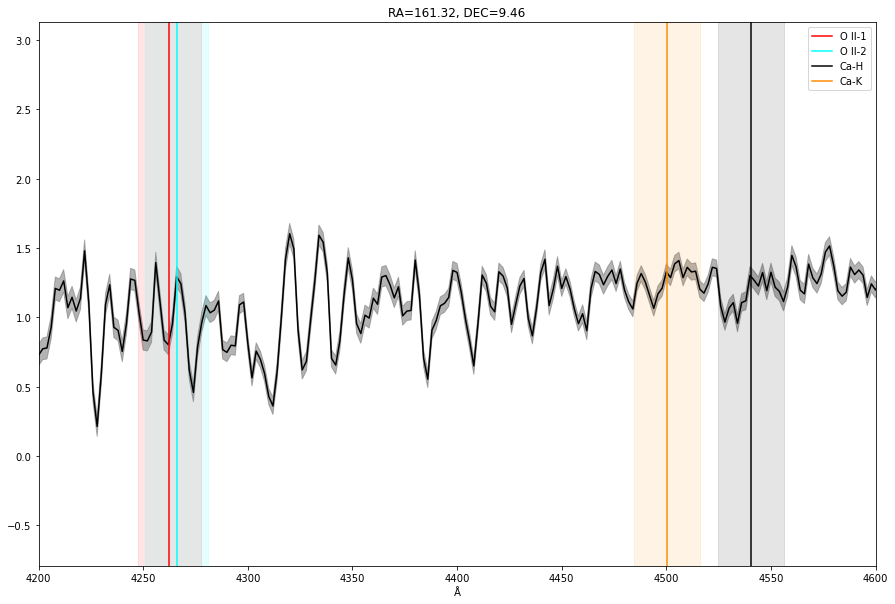

4 0


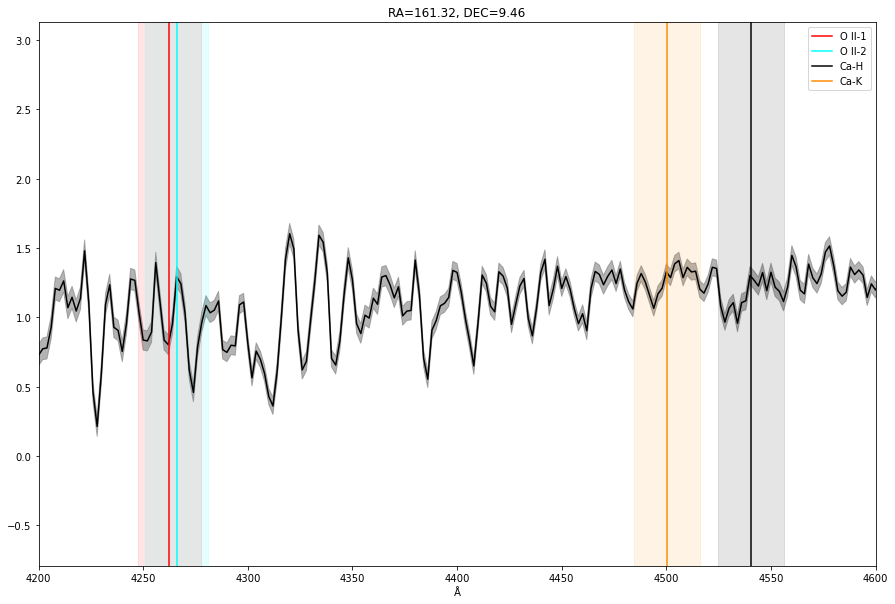

4 1


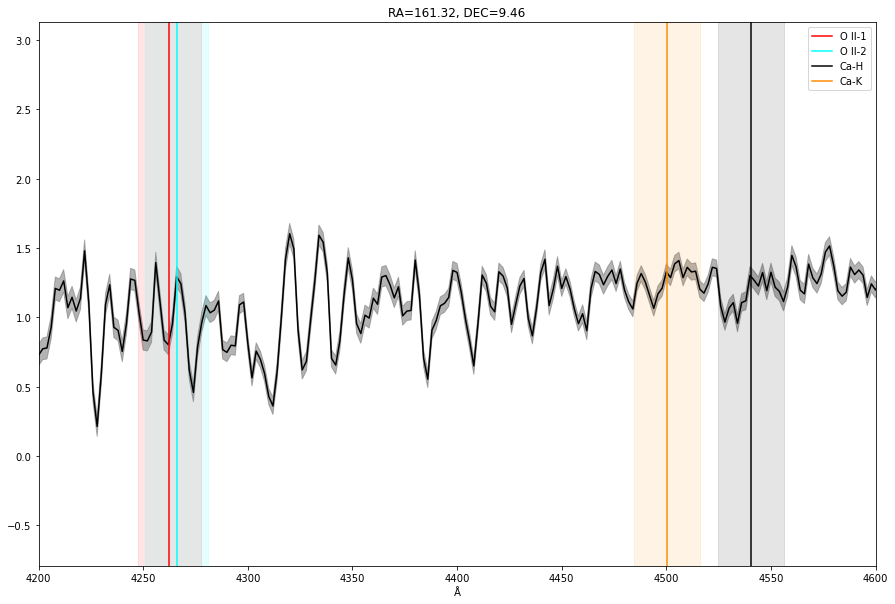

4 2


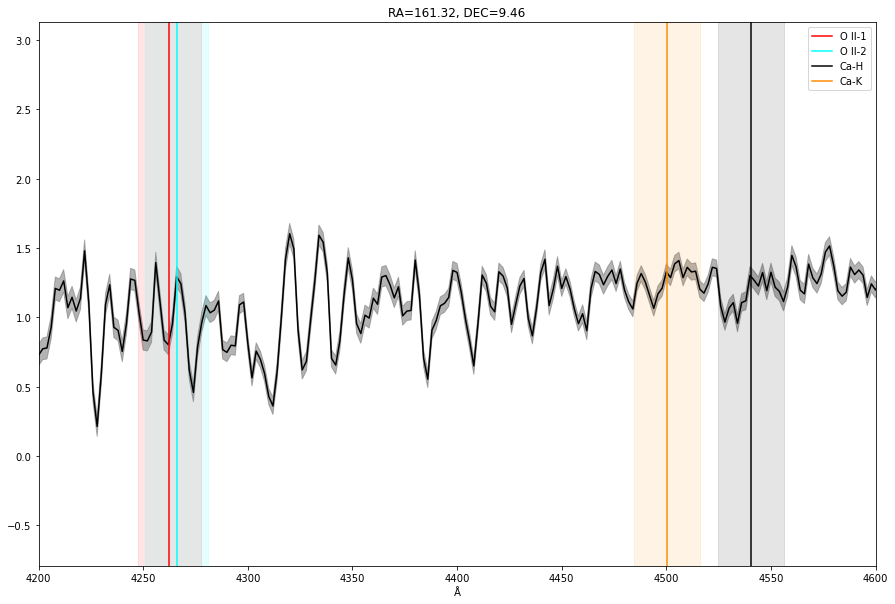

4 3


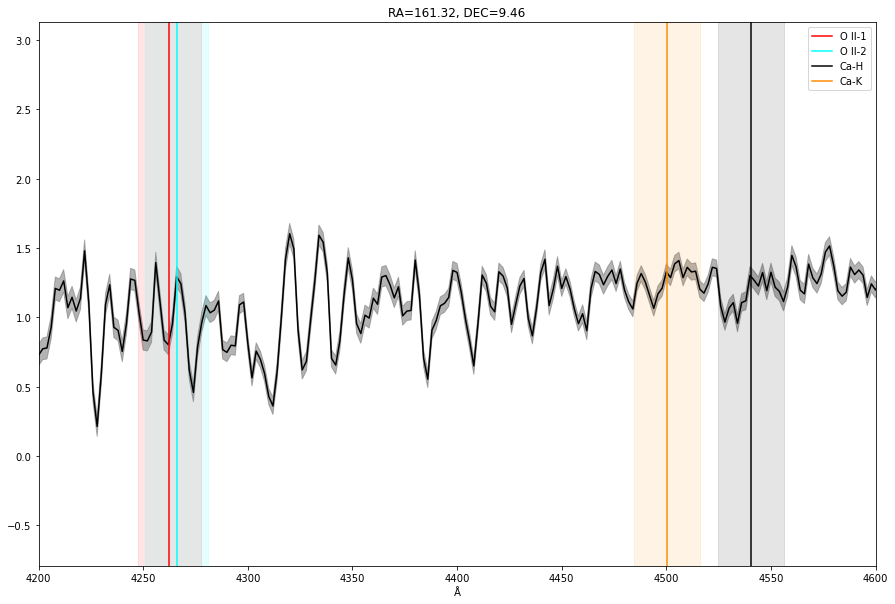

4 4


In [20]:
for i in range(5):
    for j in range(5):
        overplot(i,j,zoom1=4200,zoom2=4600)
        print(i,j)